# 1/ Analyse d’un modèle zéro-intelligence

## Vraisemblance d’un processus ponctuel


Une série de temps d'arrivée d'évènements peut être modélisé comme une réalisation d'un processus ponctuel $N$ en considérant une suite de temps $0=t_{0}<t_{1}<t_{2}<...<t_{N}<t_{N+1}=T$ dans l'intervalle [0, T] et la vraisemblance donnée par l'équation (1) suivante : 



\begin{equation}
\mathcal{L}(t_{1} ; \ldots ; t_{N})=\prod_{i=1}^{N} f^{*}(t_{i}) \tag{1}
\end{equation}

où $f(t_i)$ désigne la densitée de probabilitée en $t_i$ de l'évènement $\{\tau \leq t\}$ conditionnellement aux arrivées passées $t_1 ... t_{i-1}, \tau$ ($\tau$ étant l'instant du premier saut de $N$ aprés $t_i$)

On suppose que $N$ est simple (pas de sauts simultanés), de sorte que $\tau > t_{i-1}$

$\forall i$ fixé, et $\forall t_{i-1} < t < t_{i}$ on suppose l'existence des fonctions suivantes :
- La fonction de répartition conditionnelle 
  \begin{equation}
  F^{*}(t)=\text { Proba }\{\tau \leqslant t \mid t_{0}, \ldots, t_{i-1}\} \tag{2}
  \end{equation}
- Et sa dérivée temporelle :
  \begin{equation}
  f^{*}(t)=\frac{d F^{*}(t)}{d t} \tag{3}
  \end{equation}


###Expressions de $\mathcal{L}$

On définit également $\lambda^{*}$ comme l’intensité du processus $N$ à un temps t ($t_{i-1} < t < t_{i}$) conditionnellement aux arrivées
passées $t_1 ... t_{i-1}$.

On a alors par définition d'un processus ponctuel $N$ : 
$\lambda(t)=\lim _{\delta \rightarrow 0} \frac{\mathbb{P}[N(t+\delta)-N(t)=1 \mid \mathcal{F}_{t}]}{\delta} $ 

Et donc en utilisant la caractérisation du processus ponctuel en fonction de ses temps de sauts : 
$\lambda(t)=
 \lim _{\delta \rightarrow 0} \frac{\mathbb{P}[t<\tau \leq t+\delta \mid t_{0}, \ldots, t_{i-1}]}{\delta} =
 \lim _{\delta \rightarrow 0} \frac{\mathbb{P}[t<\tau \leq t+\delta \mid t<\tau, t_{0}, \ldots, t_{i-1}]}{\delta} $


Puis en développant la formule de probabilité conditionnelle, et enfin en utilisant la définition de la fonction de répartition :
$\lambda(t)= \lim _{\delta \rightarrow 0} \mathbb{P}[t<\tau \leq t+\delta \mid t_{0}, \ldots, t_{i-1}] / (\delta \times \mathbb{P}[t<\tau \mid t_{0}, \ldots, t_{i-1}] )
 =\lim _{\delta \rightarrow 0} \frac{F^{*}(t+\delta)-F^{*}(t)}{\delta (1-F^{*}(t))}$ 

Comme on a supposé que f existait, on obtient donc bien à la limite :
\begin{equation}
\lambda^{*}(t)=\frac{f^{*}(t)}{1-F^{*}(t)} \tag{4}
\end{equation}

Pour pouvoir développer l'expression de la vraisemblance (1), on peut donc directement intégrer l'expression de l'intensité (4) et en utilisant que la densité est la dérivée de la fonction de la répartition on obtient directement :
$\int_{t_{i-1}}^{t} \lambda^{*}(s) d s=-\log(1-F^{*}(t))$ soit $F^{*}(t)=1-\exp ^{-\int_{t_{i-1}}^{t} \lambda^{*}(s) d s}$ et donc $f^{*}(t)=\lambda^{*}(t) \exp ^{-\int_{t_{i-1}}^{t} \lambda^{*}(s) d s}$

Donc finalement on obtient bien le résultat demandé :
\begin{equation}
\mathcal{L}(t_{1} ; \ldots ; t_{N})=\prod_{i=1}^{N} f^{*}(t_{i}) = \prod_{i=1}^{N}(\lambda(t_{i}) \exp ^{-\int_{t_{i-1}}^{t_{i}} \lambda(s) d s})=(\prod_{i=1}^{N} \lambda(t_{i})) \exp ^{-\int_{0}^{T} \lambda(s) d s}) \tag{5}
\end{equation}

### Cas d’un processus de Poisson homogène

Dans le cas d'un processus de Poisson homogène, par définition l'intensité est constante et donc l'expression de la Vraisemblance (5) devient :
$\mathcal{L}(t_{1}, \ldots t_{N})=\lambda^{N} \exp (-T \lambda)$

Donc la condition du premier ordre s'écrit : $\frac{d \mathcal{L}\left(t_{1}, \ldots t_{N}\right)}{d \lambda}= (N-\bar{\lambda} T) \times \bar{\lambda}^{N-1} \times e^{-\bar{\lambda} T}=0$



On obtient donc bien :


\begin{equation}
\bar{\lambda}=\frac{N}{T} \tag{6}
\end{equation}


Ainsi la relation obtenue dans le cas d'un processus de Poisson homogène est une simple "mesure homogène", i.e. une mesure du nombre d'évènement dans un intervalle de temps donné.

## Analyse de données de Trading book

### Importations

In [ ]:
import numpy as np
from matplotlib import pyplot as plt 
import copy
import pdb
import random
import pandas as pd

In [ ]:
# Set working directory on Drive
from google.colab import drive 
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/TP1_LOB_files/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/TP1_LOB_files


### Chargement des données

In [ ]:
# intensité divisé par facteur constant 2.3 - 2.5 chaque jour
# intensités entre 0.3 et 0.7 (qq dixièmes - unités..)
# bonus : histogramme des durées entre transaction (échelle log?)
# on a un intéret à prendre un lambda star qui assure convergence (grand?)

def load_data(dates_list, trades_bool):
  filepaths_list = [date_str + '-BNPP.PA-trade.csv' for date_str in dates_list] if trades_bool else [date_str + '-BNPP.PA-book.csv' for date_str in dates_list] 
  df_list = []
  for filepath in filepaths_list:
    try:
      df = pd.read_csv(filepath)
      df.index = pd.to_datetime(df["xltime"],unit="d",origin="1899-12-30",utc=True)
      datetime_index = df.index.tz_convert('Europe/Paris')
      df.index = datetime_index
      #pdb.set_trace()
      df["date"] = df.index.to_series().apply(lambda x: x.date())
      df["time"] = df.index.to_series().apply(lambda x: x.time())
      df.drop(columns="xltime",inplace=True)
      open_time="10:00:00"
      close_time="16:00:00"
      df = df.between_time(open_time,close_time)
      df_list.append(df)
    except:
      pass
  return pd.concat(df_list)

In [ ]:
dates_list = ['2015-06-0' + str(i) for i in range(3, 10)] + ['2015-06-' + str(i) for i in range(10, 25)] 
trades_bool = True
df_trades = load_data(dates_list, trades_bool)

In [ ]:
df_trades

trade-price  ...             time
xltime                                            ...                 
2015-06-03 10:00:00.001958400+02:00        56.01  ...  10:00:00.001958
2015-06-03 10:00:00.001958400+02:00        56.01  ...  10:00:00.001958
2015-06-03 10:00:00.001958400+02:00        56.01  ...  10:00:00.001958
2015-06-03 10:00:00.001958400+02:00        56.02  ...  10:00:00.001958
2015-06-03 10:00:00.001958400+02:00        56.02  ...  10:00:00.001958
...                                          ...  ...              ...
2015-06-24 15:59:35.882016+02:00           57.00  ...  15:59:35.882016
2015-06-24 15:59:36.349008+02:00           57.00  ...  15:59:36.349008
2015-06-24 15:59:36.349008+02:00           57.00  ...  15:59:36.349008
2015-06-24 15:59:36.349008+02:00           57.00  ...  15:59:36.349008
2015-06-24 15:59:38.521968+02:00           56.99  ...  15:59:38.521968

[171750 rows x 6 columns]

### Preprocessing des données

On remarque qu'une même date peut contenir plusieurs trades comme par exemple la date suivante :

In [ ]:
df_trades.loc['2015-06-09 14:10:02.326022400+02:00']

trade-price  ...             time
xltime                                            ...                 
2015-06-09 14:10:02.326022400+02:00        54.15  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.15  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.15  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.15  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.15  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.15  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.15  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.16  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.16  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.16  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.16  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.16  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.16  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.16  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.16  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.16  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.16  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.16  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.16  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.16  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.16  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.16  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.16  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.16  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.16  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.17  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.17  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.17  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.17  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.17  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.17  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.17  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.17  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.17  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.17  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.17  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.17  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.17  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.17  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.17  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.18  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.18  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.18  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.18  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.18  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.18  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.18  ...  14:10:02.326022
2015-06-09 14:10:02.326022400+02:00        54.18  ...  14:10:02.326022

[48 rows x 6 columns]

On remarque que seulement moins de la moitié des dates ne comportent qu'une seule transaction, puis on observe une décroissance de type exponentielle.

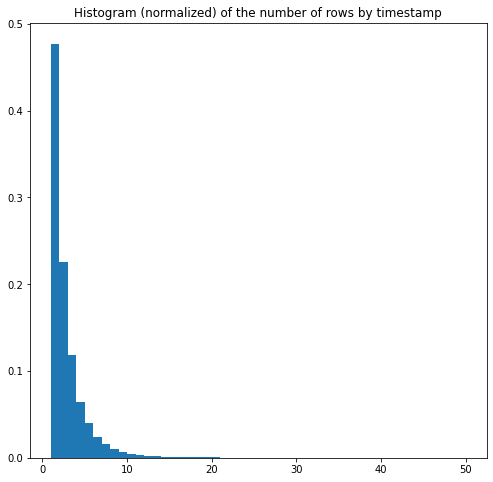

In [ ]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(121)
#ax.set_ylabel('Intensity')
ax.set_title('Histogram (normalized) of the number of rows by timestamp')
ax.hist(df_trades.index.value_counts(), bins=np.linspace(1, 50, 50), density=True)
plt.show()


On choisit ainsi de regrouper les trades le plus intelligemment possible. Il s'agit de définir un trade en fonction des variables à notre disposition. Il parait tout d'abord évident de devoir distinguer un trade par sa date et le trade-price.  Il reste donc à vérifier si les variables 'trade-stringflag' et 'trade-rawflag' peuvent jouer un rôle. Pour cela on vérifie tout d'abord si l'on peut voir des lignes de même date et même prix avec des valeurs différentes pour ces variables.

In [ ]:
df_stringflag = df_trades.groupby(['date', 'time', 'trade-price'])['trade-stringflag'].nunique()
df_stringflag[df_stringflag > 1]

date        time             trade-price
2015-06-09  14:36:35.965036  54.34          2
Name: trade-stringflag, dtype: int64

In [ ]:
df_rawflag = df_trades.groupby(['date', 'time', 'trade-price'])['trade-rawflag'].nunique()
df_rawflag[df_rawflag > 1]

date        time             trade-price
2015-06-03  10:03:50.494003  55.97          2
            11:24:08.562960  56.16          2
            12:01:56.414956  56.15          2
            12:05:58.666041  56.19          2
            12:06:13.205001  56.20          2
                                           ..
2015-06-24  11:36:53.827977  56.24          2
            11:37:12.015004  56.18          2
            11:37:18.153033  56.14          2
            11:37:19.613020  56.08          2
            11:37:19.644038  56.07          2
Name: trade-rawflag, Length: 562, dtype: int64

Il est difficile de tirer des conclusions puisque quelques trades semblent en effet se distinguer par ces variables. étant donné leur nombre faible relativement à la taille du dataset on décide de ne pas en tenir compte et donc d'aggréger les trades au niveau date+prix. Ce choix doit être en réalité effectué en cohérence avec problème que l'on souhaite traiter.

In [ ]:
def group_trades(df_trades):
  # à réecrire mieux
  df_trades_new = pd.DataFrame(df_trades.groupby(['date', 'time', 'trade-price'])[['trade-volume', 'trade-price']].agg({'trade-volume' : 'sum', 'trade-price' : 'first'})).reset_index(['date', 'time']).drop(columns = ['trade-price']).reset_index()
  df_trades_new['datetime'] = pd.to_datetime(df_trades_new['date'].astype(str) + ' ' + df_trades_new['time'].astype(str))
  df_trades_new.index = df_trades_new['datetime']
  return df_trades_new

In [ ]:
df_trades = group_trades(df_trades)

In [ ]:
df_trades

trade-price  ...                   datetime
datetime                                 ...                           
2015-06-03 10:00:00.001958        56.01  ... 2015-06-03 10:00:00.001958
2015-06-03 10:00:00.001958        56.02  ... 2015-06-03 10:00:00.001958
2015-06-03 10:00:00.011980        56.01  ... 2015-06-03 10:00:00.011980
2015-06-03 10:00:00.297014        56.01  ... 2015-06-03 10:00:00.297014
2015-06-03 10:00:00.647020        56.02  ... 2015-06-03 10:00:00.647020
...                                 ...  ...                        ...
2015-06-24 15:59:20.110992        56.96  ... 2015-06-24 15:59:20.110992
2015-06-24 15:59:35.852985        56.99  ... 2015-06-24 15:59:35.852985
2015-06-24 15:59:35.882016        57.00  ... 2015-06-24 15:59:35.882016
2015-06-24 15:59:36.349008        57.00  ... 2015-06-24 15:59:36.349008
2015-06-24 15:59:38.521968        56.99  ... 2015-06-24 15:59:38.521968

[76029 rows x 5 columns]

Maintenant pour choisir l'unité "naturelle" de l'intensité de notre dataset, on plot un histogramme des durées inter-trades pour chaque jour :

In [ ]:
def get_intertime(df_trades):
  df_trades['inter_seconds'] = df_trades['datetime'].diff().dt.total_seconds()
  df_trades['date_shift'] = df_trades['date'].shift(1)
  df_trades['new_day'] = (df_trades['date_shift'] != df_trades['date'])*1
  df_trades.loc[df_trades.new_day == 1, 'inter_seconds'] = np.nan
  df_trades.drop(columns = ['date_shift', 'new_day'], inplace = True)
  return df_trades

In [ ]:
df_trades = get_intertime(df_trades)

In [ ]:
df_trades['inter_seconds'].value_counts().reset_index().sort_values(by='index')

index  inter_seconds
0        0.000000           4095
9        0.000950            635
14       0.000951            387
21       0.001036            258
5        0.001037           1084
...           ...            ...
12889  111.705004              1
15673  120.646022              1
20103  121.773974              1
15885  129.293971              1
14560  142.873977              1

[23828 rows x 2 columns]

In [ ]:
def plot_inter_times(df_trades):
  fig = plt.figure(figsize=(18,8))
  mean_delta = df_trades['inter_seconds'].mean()
  med_delta = df_trades['inter_seconds'].median()
  big_title = 'Inter-trades time (mean = ' + str(mean_delta) + ', med = ' + str(med_delta) + ')'
  st = fig.suptitle(big_title, fontsize="x-large")
  st.set_y(0.95)
  fig.subplots_adjust(top=0.85)
  ax = fig.add_subplot(131)
  ax.hist(df_trades['inter_seconds'], bins=np.linspace(0, 100, 100), density=True)
  ax2 = fig.add_subplot(132)
  ax2.hist(df_trades['inter_seconds'], bins=np.linspace(0, 10, 100), density=True)
  ax3 = fig.add_subplot(133)
  ax3.hist(df_trades['inter_seconds'], bins=np.linspace(0, 1, 100), density=True)
  plt.show()

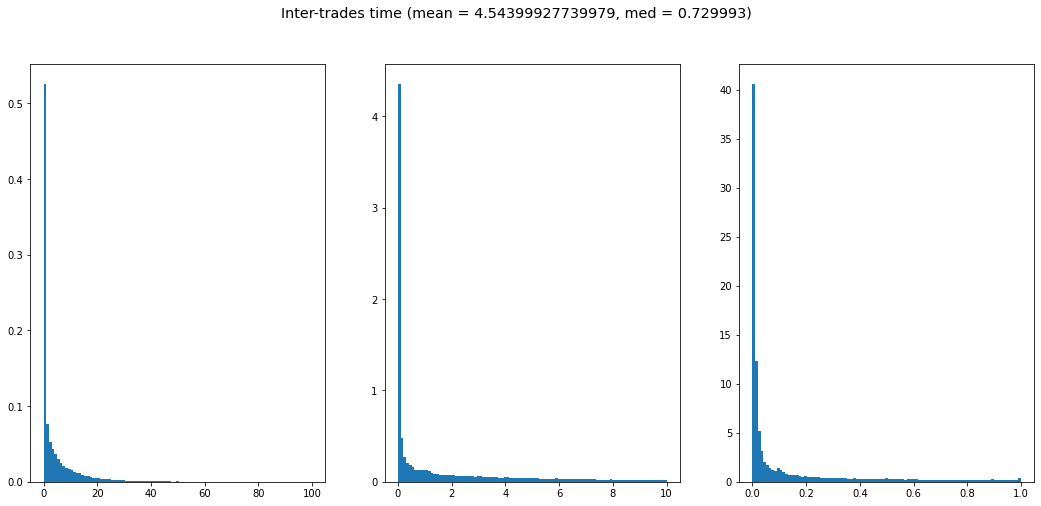

In [ ]:
plot_inter_times(df_trades)

On fait la même étude sur chaque jour présent dans les données :

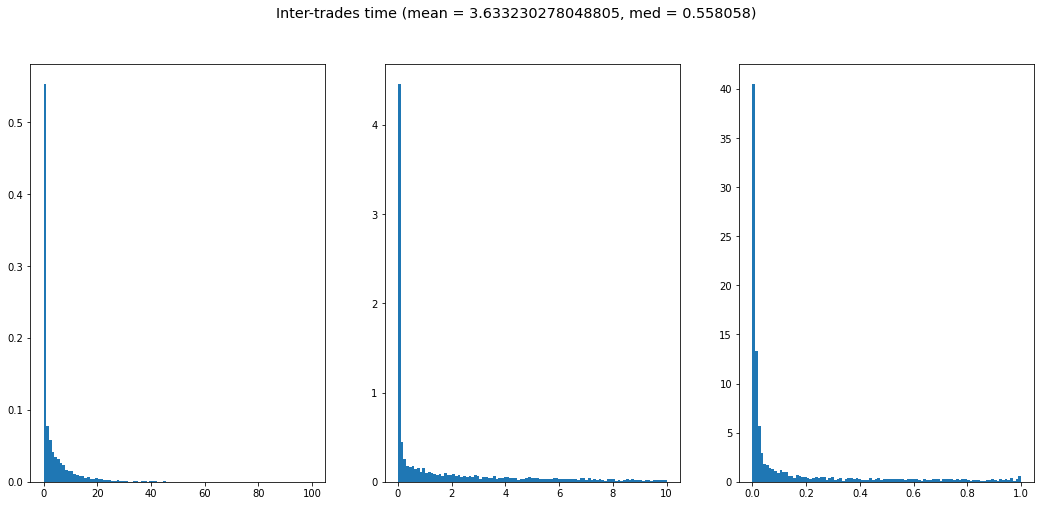

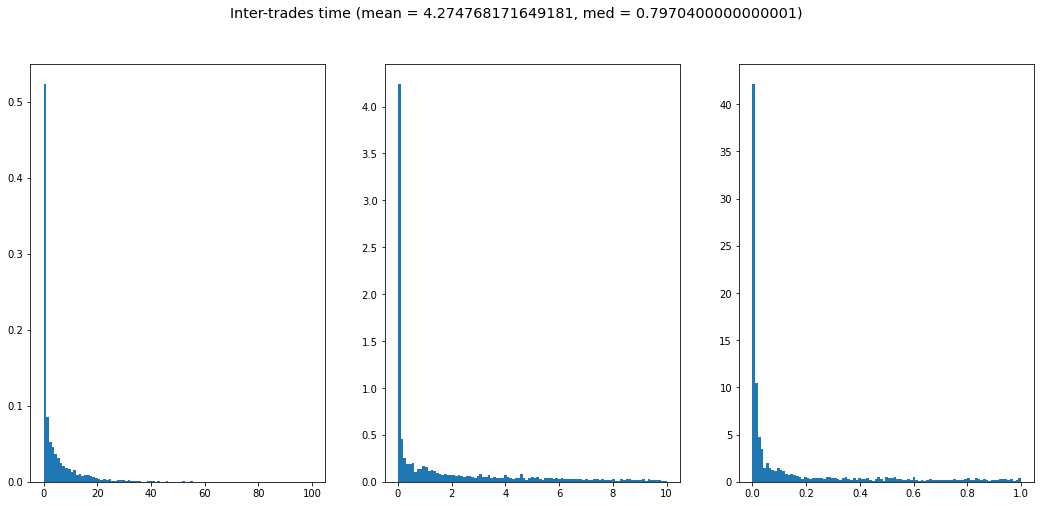

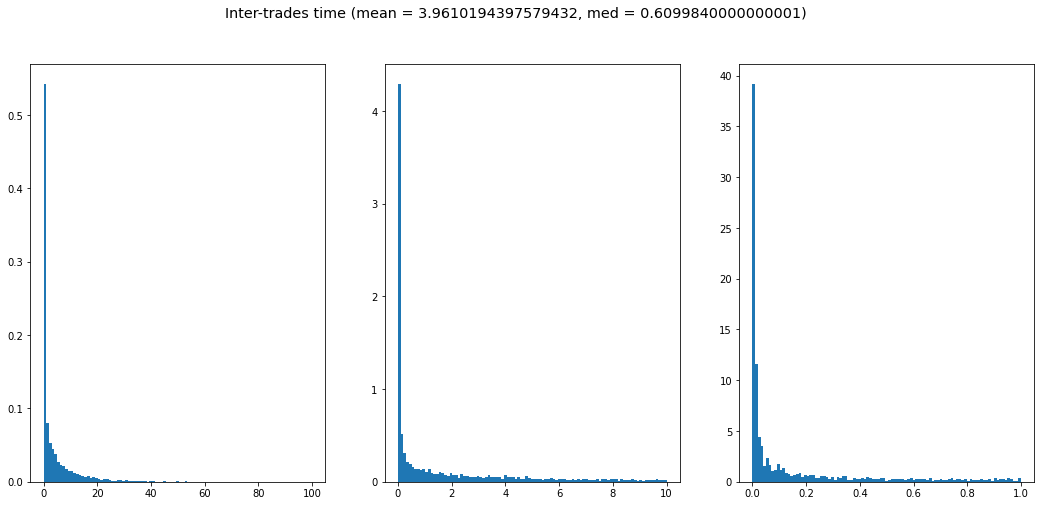

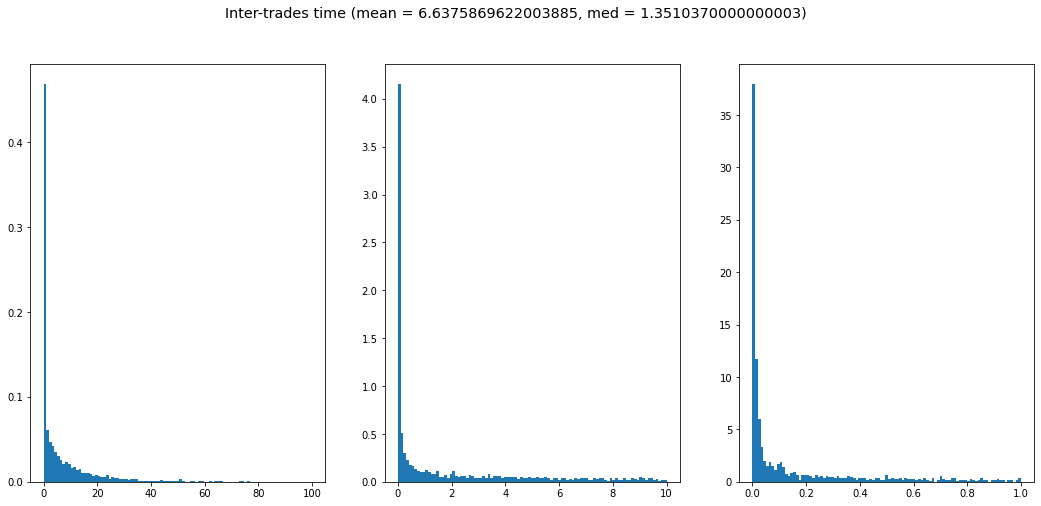

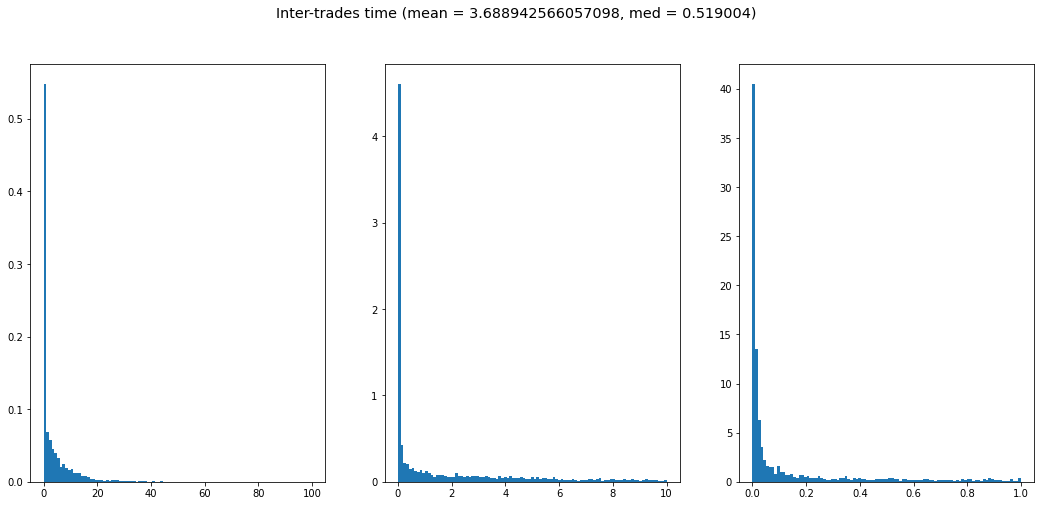

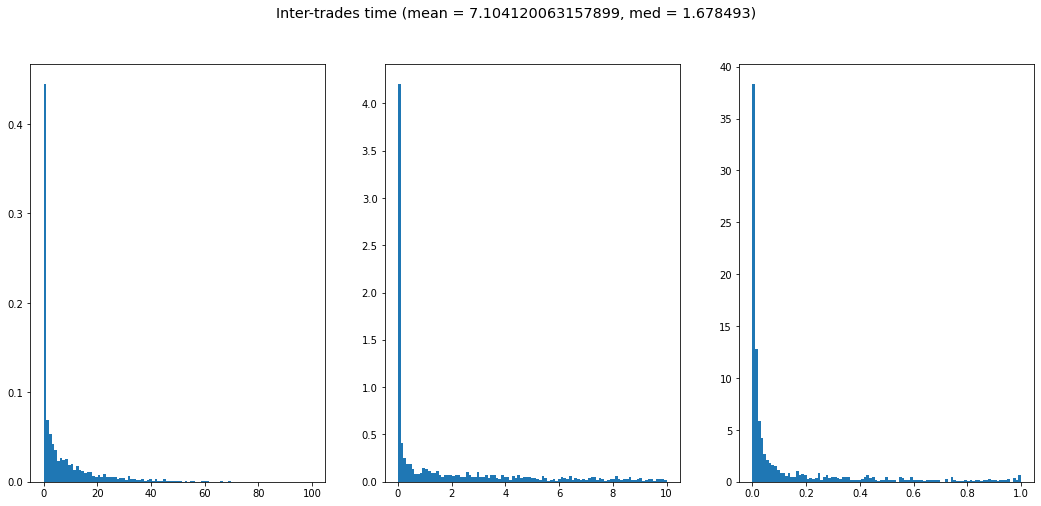

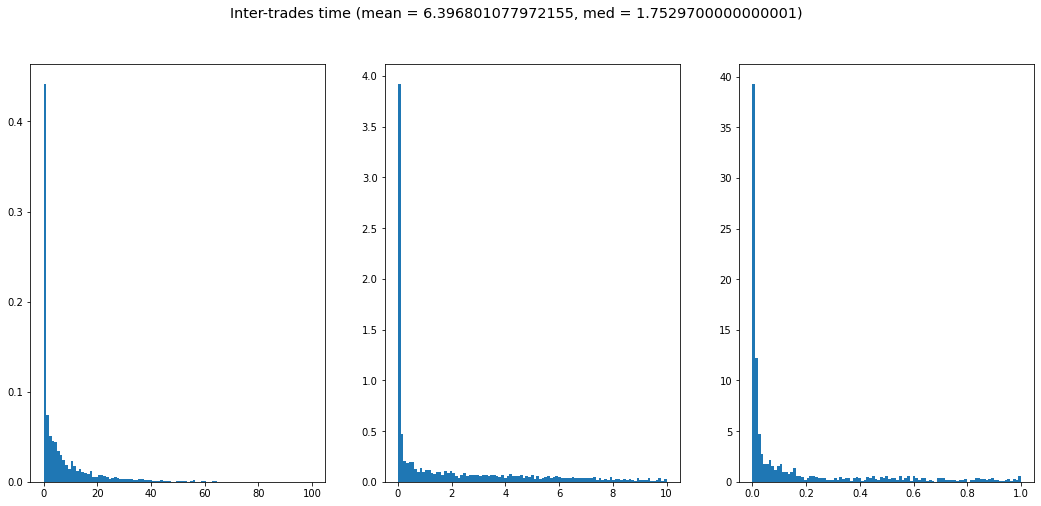

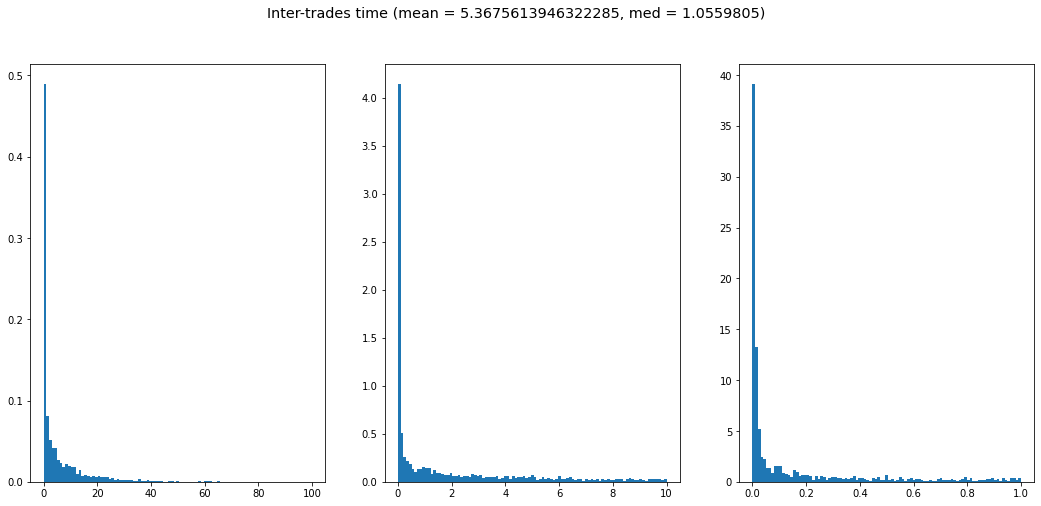

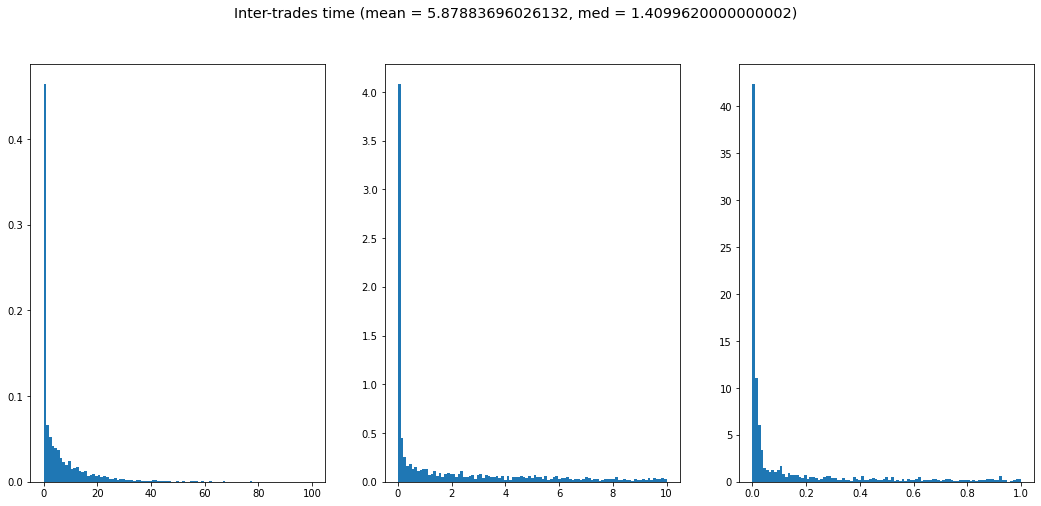

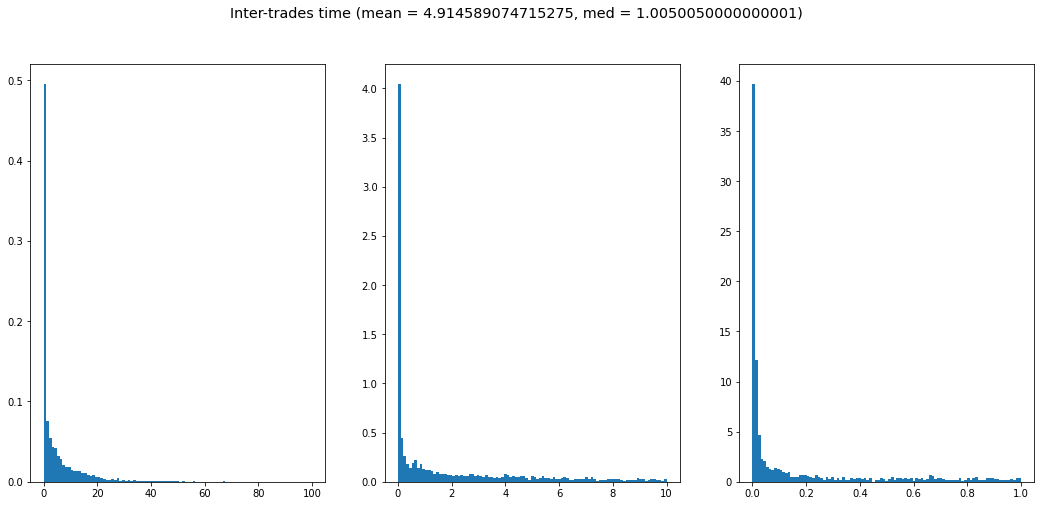

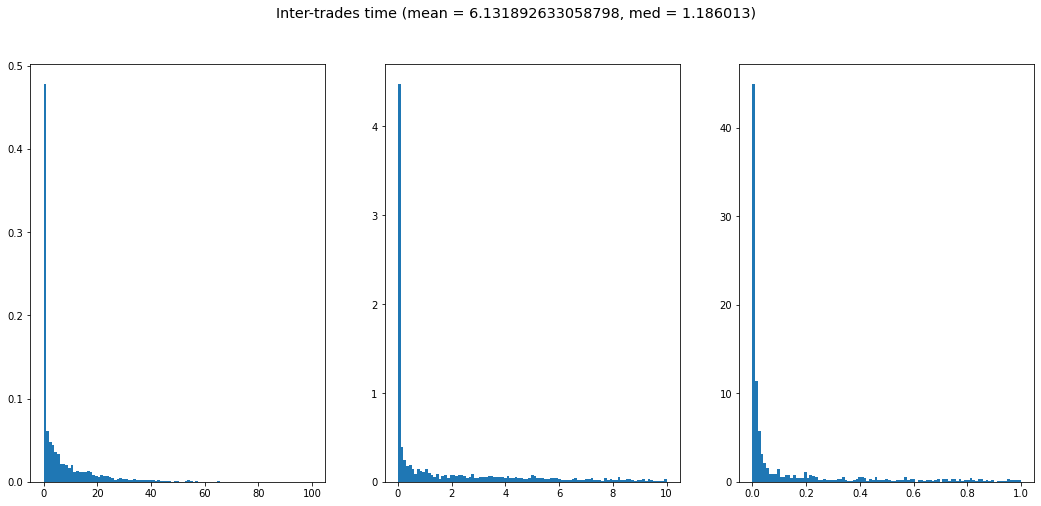

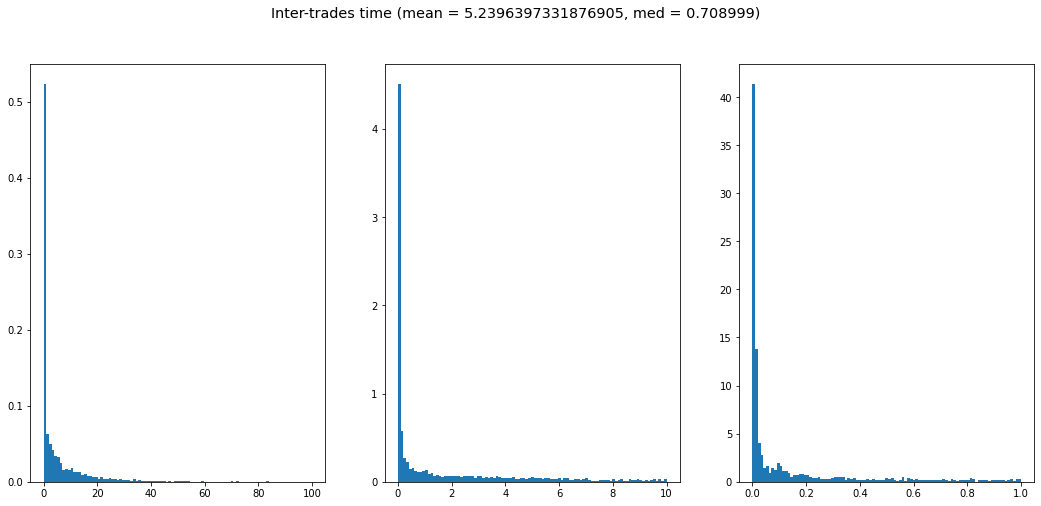

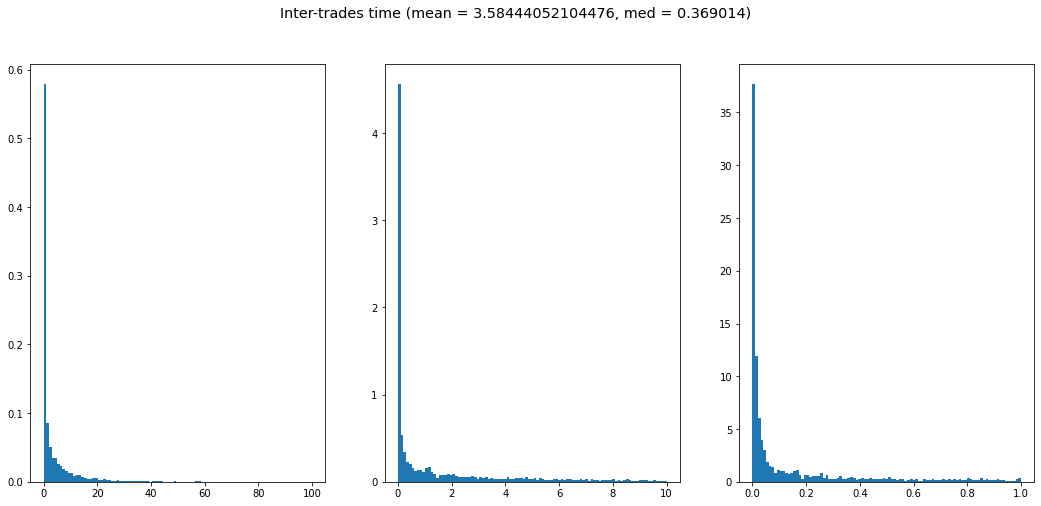

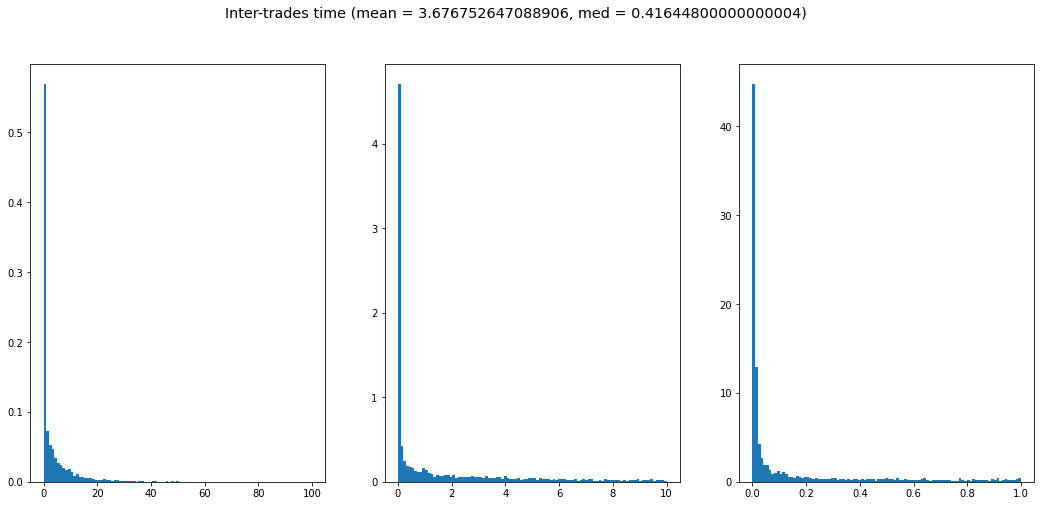

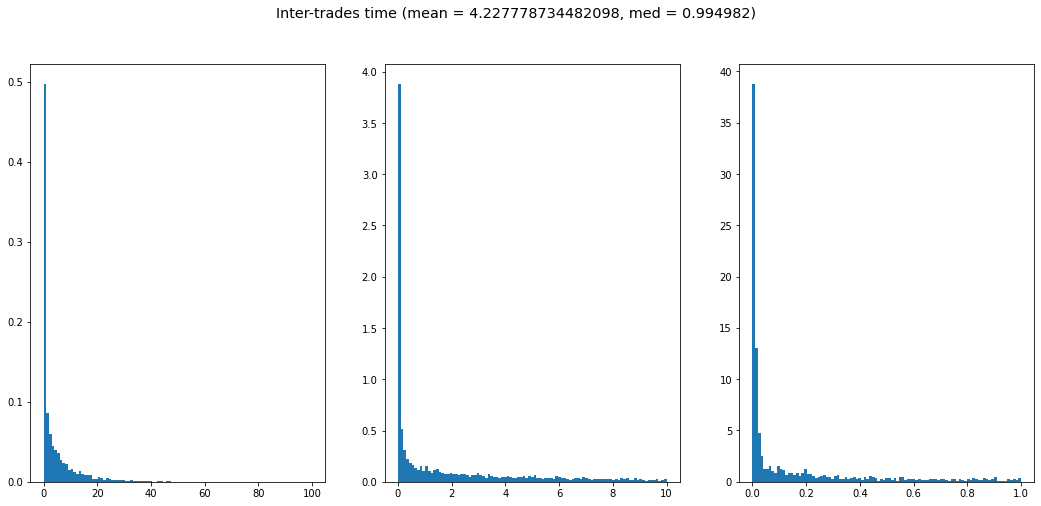

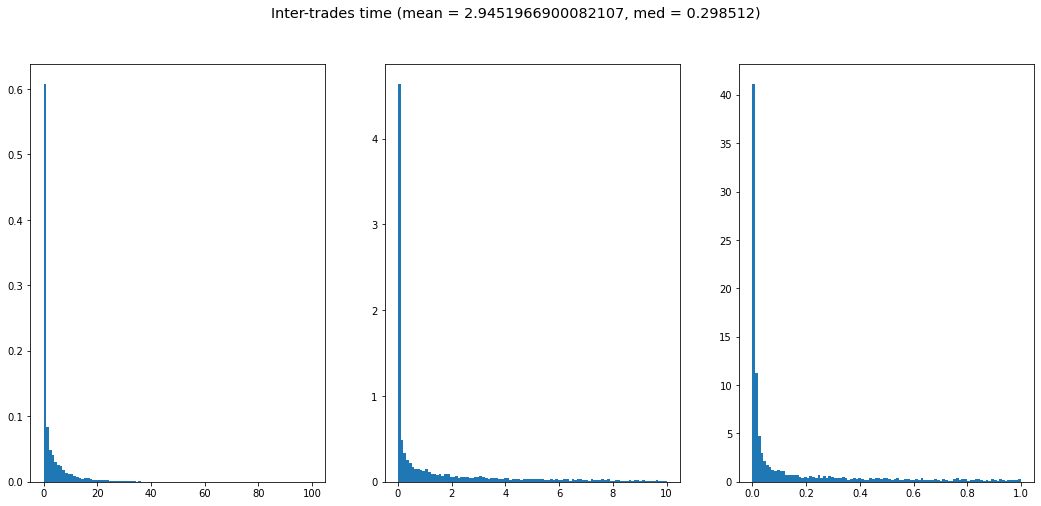

In [ ]:
for day in df_trades.date.unique():
  plot_inter_times(df_trades[df_trades.date == day])

La seconde comme unité pour l'intensité semble donc être un bon choix bien que les données soient très inhomogènes (différence moyenne/médiane).
On pourra étudier l'impact d'un choix plus faible comme $10^{-1}$ secondes par la suite.

### Processus de Poisson à intensité constante

Pour calculer l'intensité d'un processus de Poisson dans le cas constant on utilise la formule (6) obtenue précédemment : $\bar{\lambda}=\frac{N}{T} \tag{6}$
Les fonctions suivantes nous permettent d'implémenter ce calcul à partir de nos données. On compte simplement le nombre d'évènements N (=trades) dans un intervalle de temps donné $T$.

In [ ]:
def get_trade_count(df_trades, resample_str):
  agg_col_count = resample_str + '_count'
  df_trades[agg_col_count] = df_trades['trade-price'].resample(resample_str).transform('count') # ici on considère un trade = un trade price -> vérif
  return df_trades

def get_poisson_intensities(df_trades, resample_str, T):
  colname_intensities = resample_str + '_intensities' 
  df_trades = get_trade_count(df_trades, resample_str)
  df_trades[colname_intensities] = df_trades[resample_str + '_count']/T
  return df_trades

def get_and_plot_intensities(df_trades, unities_in_secondes, N_hours, resample_str, unities_str):
  df_trades = get_poisson_intensities(df_trades, resample_str, T)
  fig = plt.figure(figsize=(18,8))
  ax = fig.add_subplot(121)
  ax.set_ylabel('Intensity')
  ax.set_title('Averaged Poisson Process Intensities ' + str(unities_str) + ' by day')
  ax.plot(df_trades[resample_str + '_intensities' ], 'ro-')
  plt.show()
  return df_trades

#### Jour par Jour

On commence par calculer nos intensités sur l'ensemble des 6h de la journée retenues. On a alors $T = 3600 \times 6 \ \text{secondes}$

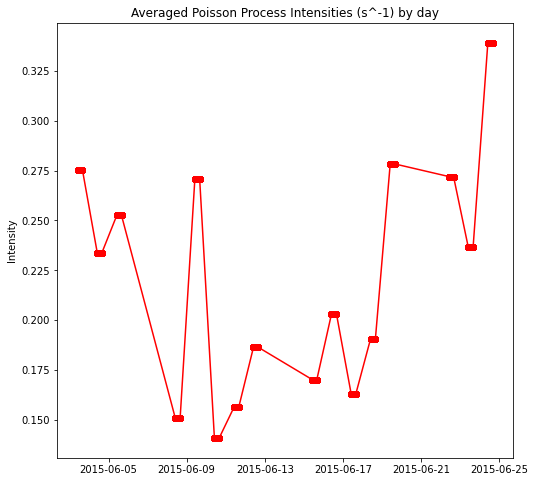

In [ ]:
unities_in_secondes = 1 # Intensities in second^-1
N_hours = 6
T = 3600*(N_hours)/unities_in_secondes # référentiel en secondes
resample_str = 'D'
unities_str = '(s^-1)'
df_trades = get_and_plot_intensities(df_trades, unities_in_secondes, N_hours, resample_str, unities_str)

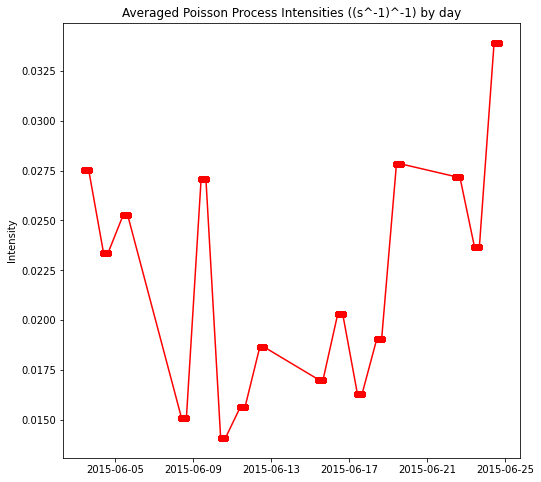

In [ ]:
unities_in_secondes = 0.1 # Intensities in second^-1
N_hours = 6
T = 3600*(N_hours)/unities_in_secondes # référentiel en secondes
resample_str = 'D'
unities_str = '((s^-1)^-1)'
df_trades = get_and_plot_intensities(df_trades, unities_in_secondes, N_hours, resample_str, unities_str)
# normal pas de diff ici

On ne remarque pas spécialement d'effet de type saisonnalité. On garde une seconde comme période tant que c'est négligeable par rapport aux quantités d'études.

Il pourrait être intéréssant de comparer ces résultats dans le cas où l'on considère des intervalles de temps très réduit pour calculer nos intensités.

#### Par tranche de 2 heures

Nous nous intéressons désormais à des tranches de 2 heures : 10h-12h, 12h-14h, 14h-16h.

In [ ]:
def get_and_plot_intensities_by_day(df_trades, unities_in_secondes, N_hours, resample_str, unities_str):
  df_trades = get_poisson_intensities(df_trades, resample_str, T)
  for day in df_trades.date.unique(): #day by day
    fig = plt.figure(figsize=(18,8))
    ax = fig.add_subplot(121)
    ax.set_ylabel('Intensity'); ax.set_xlabel('Hour')
    ax.set_title('Poisson Process Intensities ' + str(unities_str) + ', on ' + str(day))
    ax.set_xticklabels([])
    df_trades_day = df_trades[df_trades.date==day]
    ax.plot(df_trades_day[resample_str + '_intensities'], 'ro-')
    plt.show()
  return df_trades

def get_and_plot_average_intensities_hours(df_trades, resample_str, period_hours):
  # Aggregate
  df_trades['hour'] = df_trades['datetime'].dt.hour
  df_trades[resample_str + '_intensities_averaged'] =  df_trades.groupby(df_trades.hour // period_hours * period_hours)['2H_intensities'].transform('mean')
  # Plot
  fig = plt.figure(figsize=(18,8))
  ax = fig.add_subplot(121)
  ax.set_ylabel('Intensity'); ax.set_xlabel('Hour')
  ax.set_title('Averaged Poisson Process Intensities ' + str(unities_str))
  ax.set_xticklabels([])
  ax.plot(df_trades[df_trades.date == df_trades.date[0]][resample_str + '_intensities_averaged'], 'ro-')
  plt.show()
  return df_trades

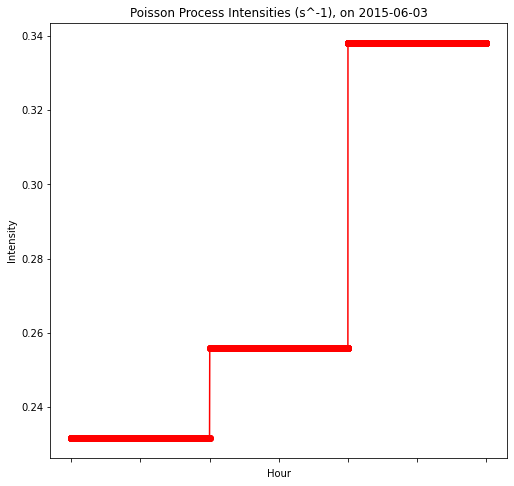

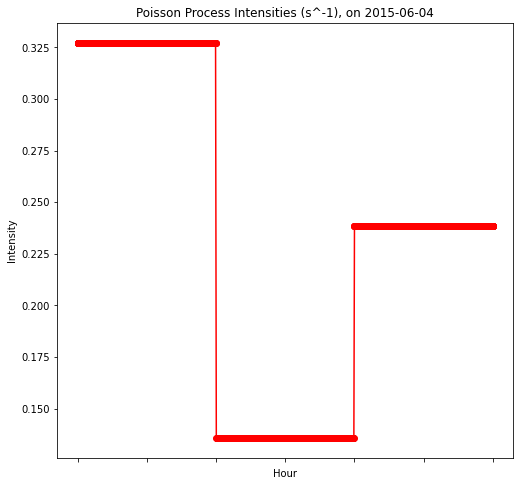

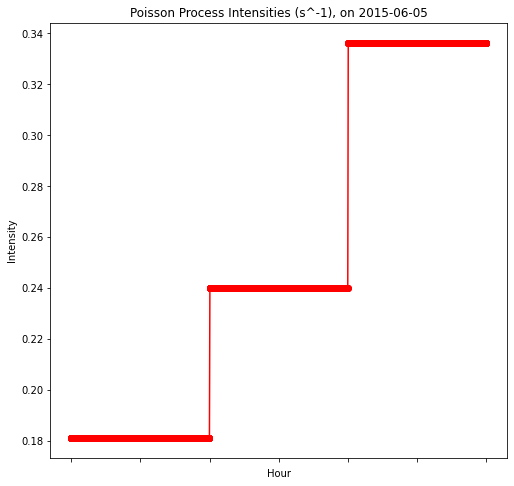

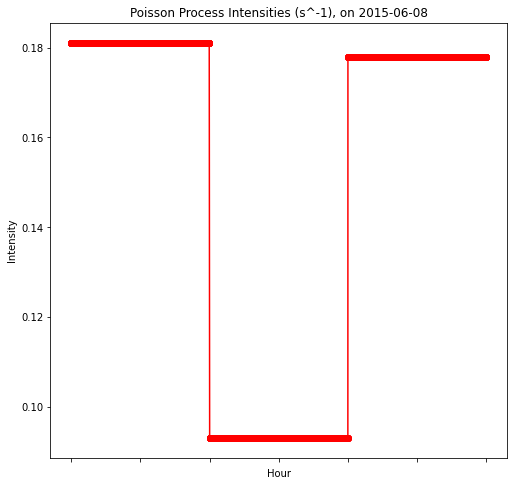

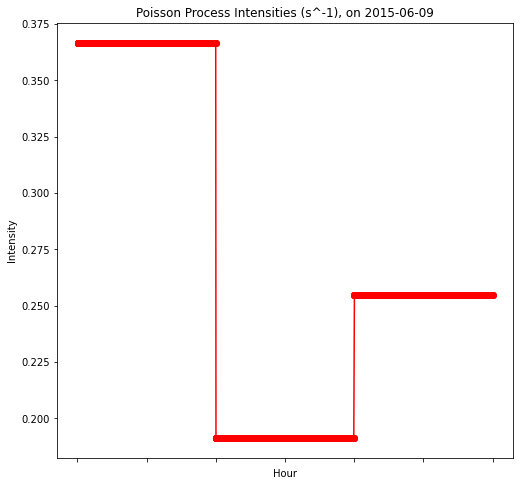

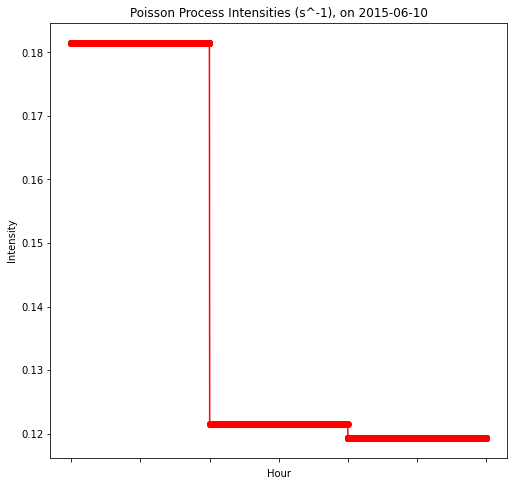

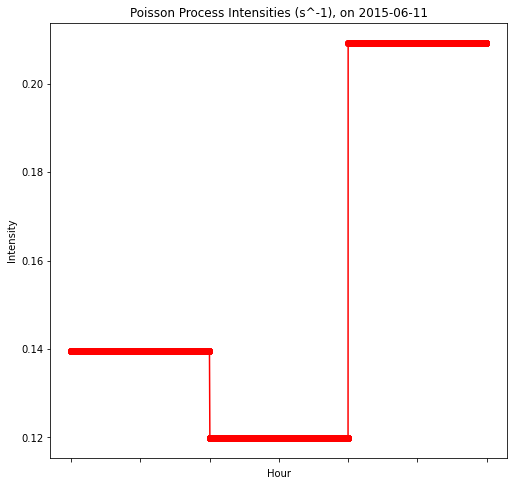

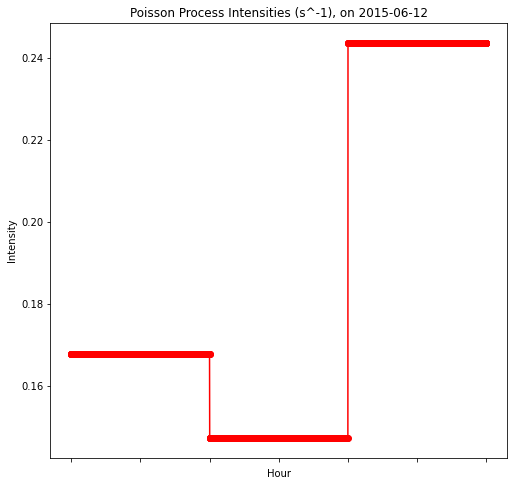

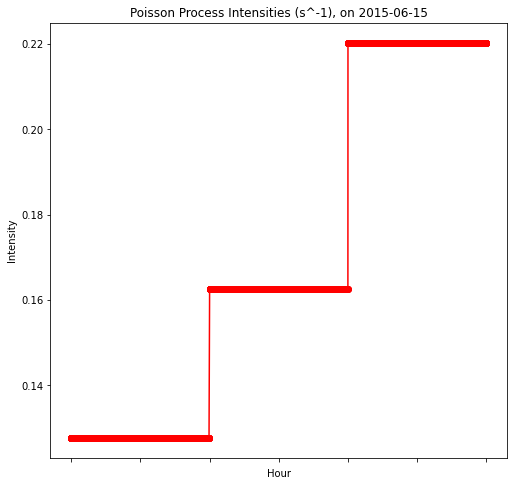

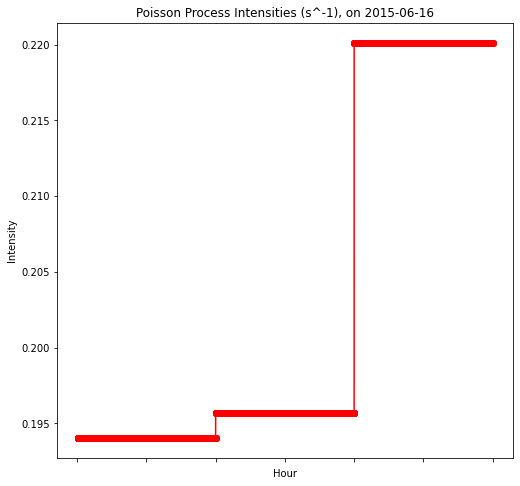

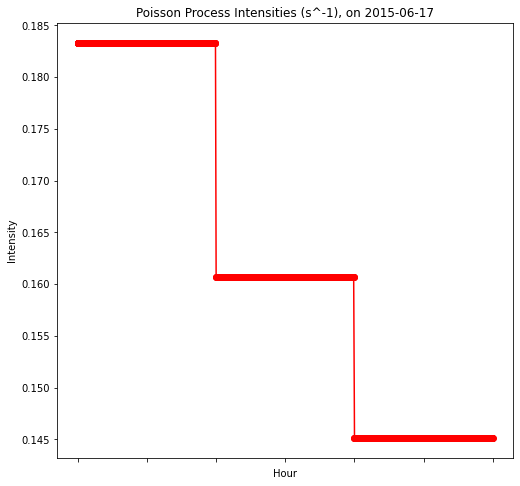

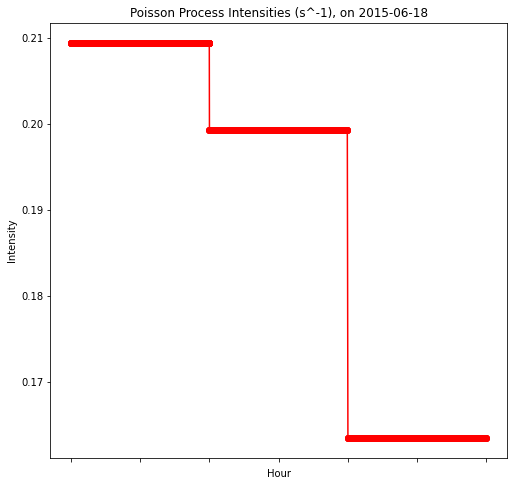

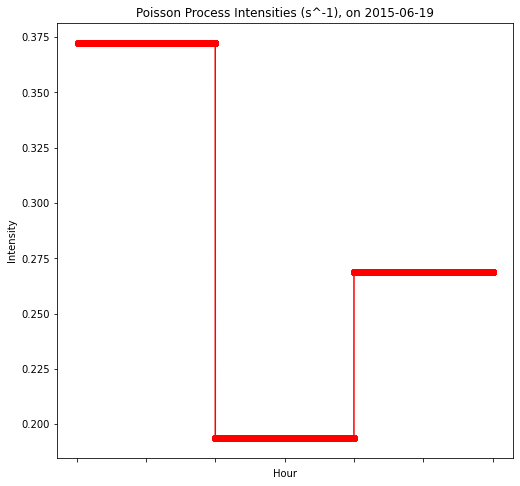

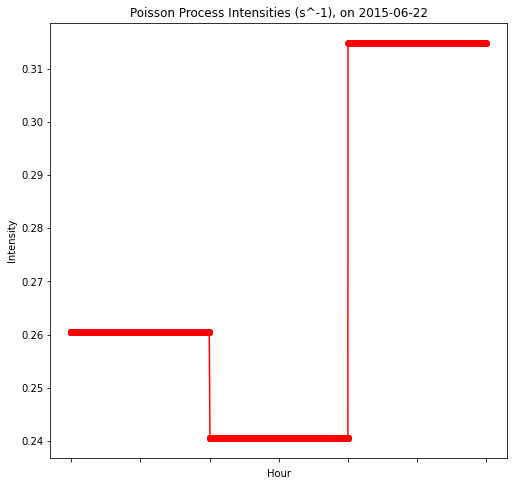

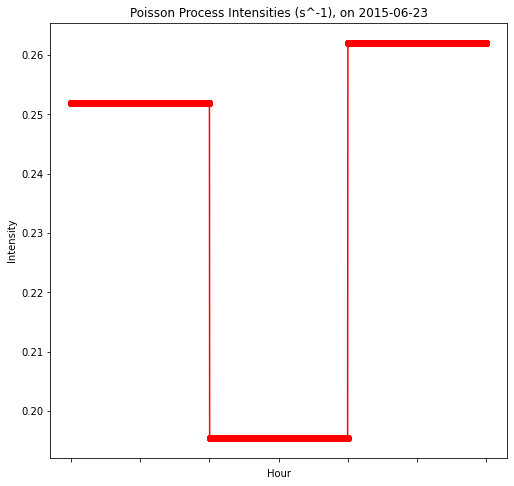

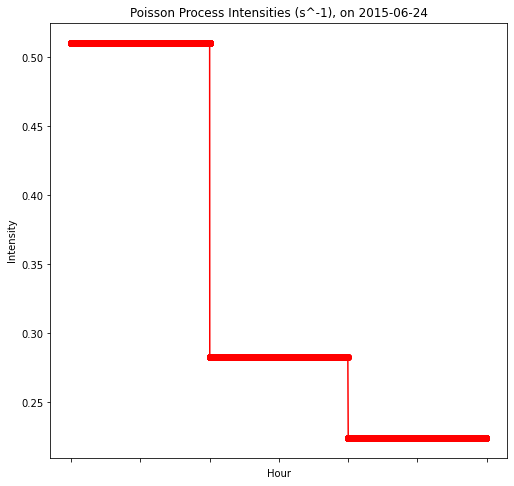

In [ ]:
unities_in_secondes = 1 # Intensities in second^-1
N_hours = 2
T = 3600*(N_hours)/unities_in_secondes # référentiel en secondes
resample_str = '2H'
unities_str = '(s^-1)'
df_trades = get_and_plot_intensities_by_day(df_trades, unities_in_secondes, N_hours, resample_str, unities_str)

Il est difficile de tirer des conclusions à partir de ces graphiques, si ce n'est que les données ne semblent pas présenter de saisonnalité, i.e. il ne semble pas y avoir certains jours où l'activité est différente (par exemple en début ou fin de semaine). Ils nous permettront tout de même de comparer nos résultats jours par jours dans la suite.

Pour tirer des conclusions sur les périodes intra-day on moyenne nos résultats précédents sur l'ensemble des jours :


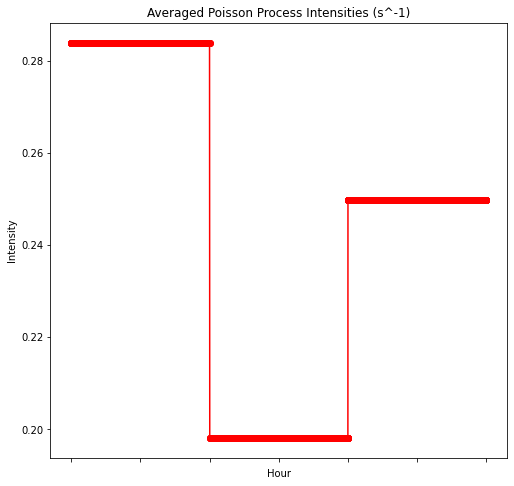

In [ ]:
period_hours = N_hours
df_trades = get_and_plot_average_intensities_hours(df_trades, resample_str, period_hours)

On retrouve ainsi la forme en U comme celle connue pour la volatilité. Ainsi on observe une activité de trading moyenne plus importante en début de journée, et dans une moindre mesure en fin de journée. La différence est significative puisque l'intensité de 10h à 12h (resp. de 14h à 16h) est 40% (resp. 25%)  plus élevée que de 12h à 14h.

Cela pourrait s'expliquer par plusieurs raisons pratiques :
- Activité plus faible lors du déjeuner.
- Activité plus importante en début de journée car ouverture/cloture de positions.
- Activité importante en début d'après midi car correspond à l'ouverture de la bourse aux USA, et en fin d'après midi car ouverture/cloture de positions.


Pour une analyse plus fine il faut tracer les histogrammes de ces intensités, par tranches horaires :

In [ ]:
def plot_hist_from_intensities(df_trades, time_sets, resample_str, bool_long_title):
  '''
  df_trades needs intensities columns already computed
  '''
  str_intensities = resample_str + '_intensities'
  figsize = (7,18*(int(len(time_sets)/10)+1))
  fig, ax = plt.subplots(nrows=len(time_sets)-1, ncols=1, figsize=figsize) 
  plt.gcf().subplots_adjust(hspace = 0.3)
  for i in range(len(ax)):
    ax[i].hist(df_trades.between_time(time_sets[i], time_sets[i+1])[str_intensities])
    ax[i].set_ylabel('Intensité')#;ax.set_xlabel("Steps")
    if bool_long_title:
      ax[i].set_title("Intensités entre " + str(time_sets[i]) + " et " + str(time_sets[i+1]) + ". Mean = " + str(round(df_trades.between_time(time_sets[i], time_sets[i+1])[str_intensities].mean(), 2)))
    else: 
      ax[i].set_title(str(time_sets[i]) + "-" + str(time_sets[i+1]) + ". Mean = " + str(round(df_trades.between_time(time_sets[i], time_sets[i+1])[str_intensities].mean(), 2)))
  plt.show()

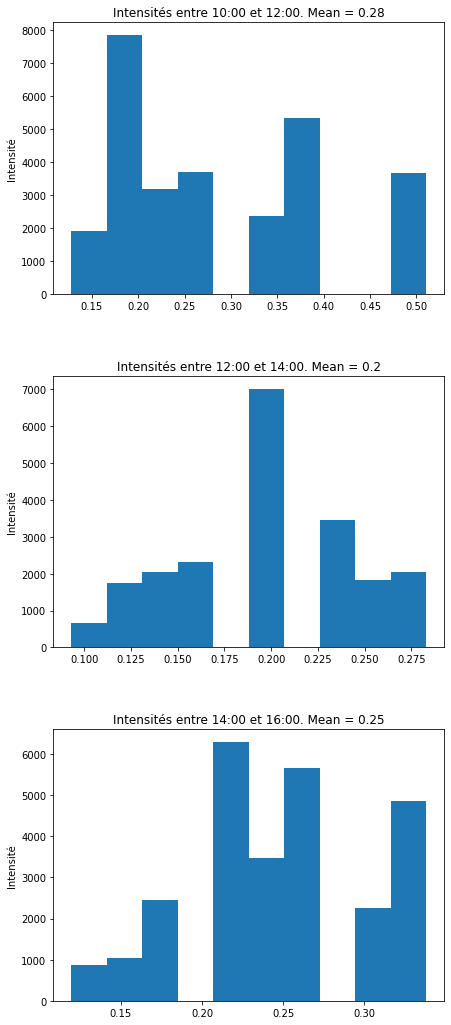

In [ ]:
resample_str = '2H'
time_sets = ['10:00', '12:00', '14:00', '16:00']
bool_long_title = True
plot_hist_from_intensities(df_trades, time_sets, resample_str, bool_long_title)

On peut apprécier les densités très différentes entres ces tranches horaires. Il est intéréssant de noter l'aspect "quasi-gaussien" entre 12h et 14h alors ques les autres tranches horaires semblent présenter des queues de distribution plus longues. Intuitivement, l'activité est moins volatile à l'heure du déjeuner.

#### Heure par heure

Puisque nos fonctions écrites nous le permettent facilement et que ça pourrait permettre une analyse plus fine, nous décidons de répéter l'étude précédente avec des périodes d'une seule heure :

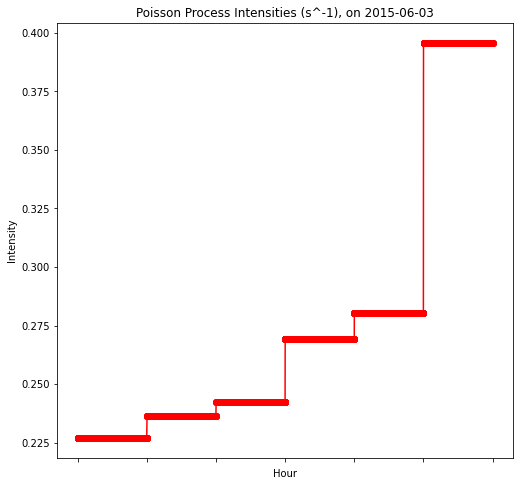

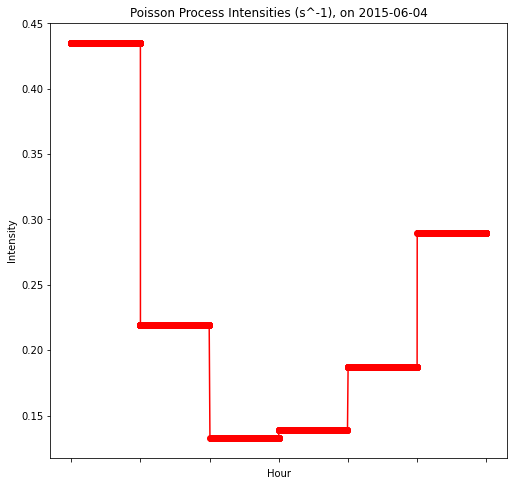

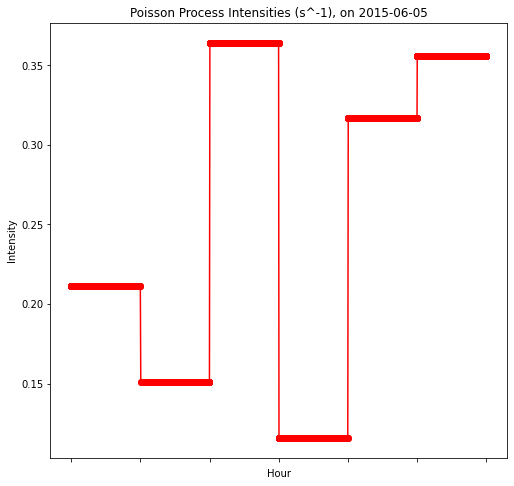

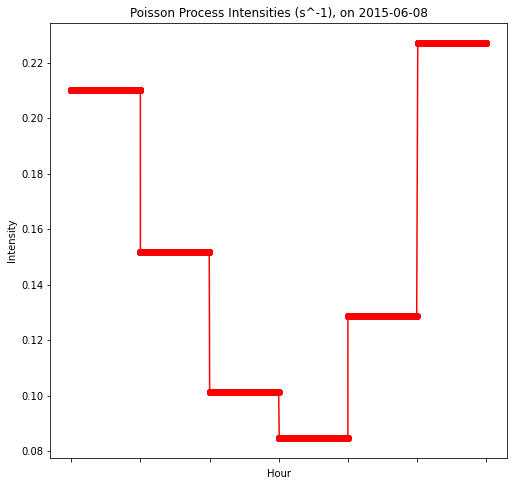

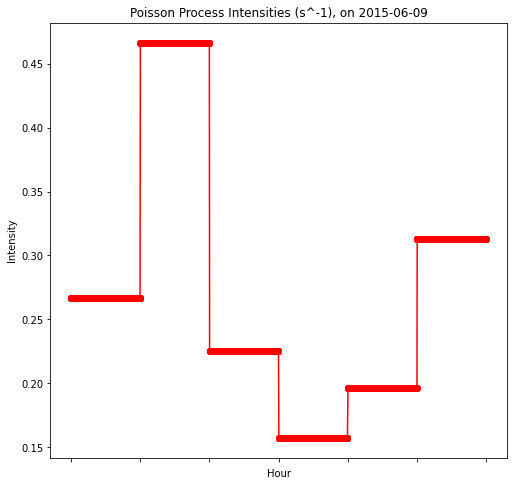

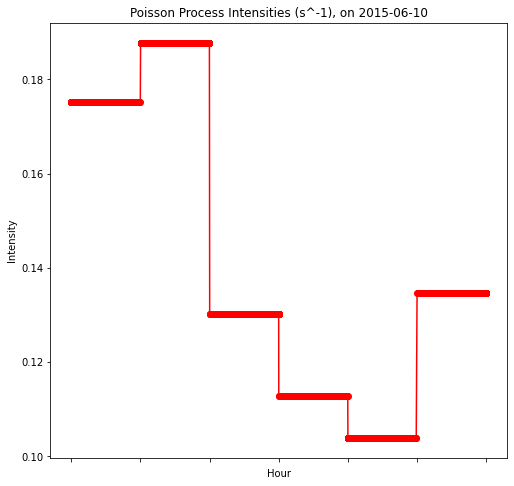

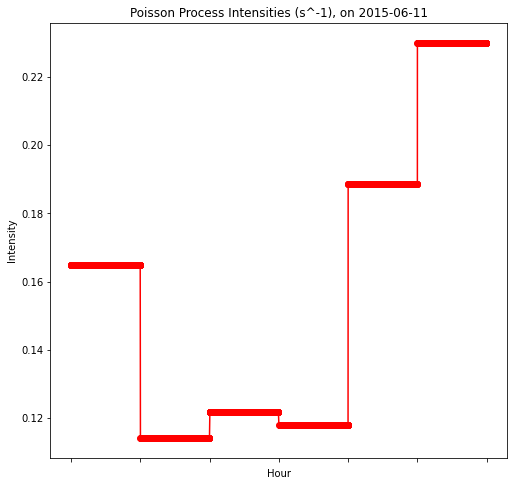

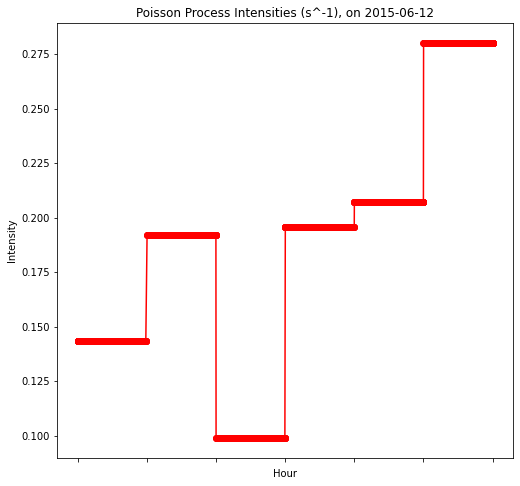

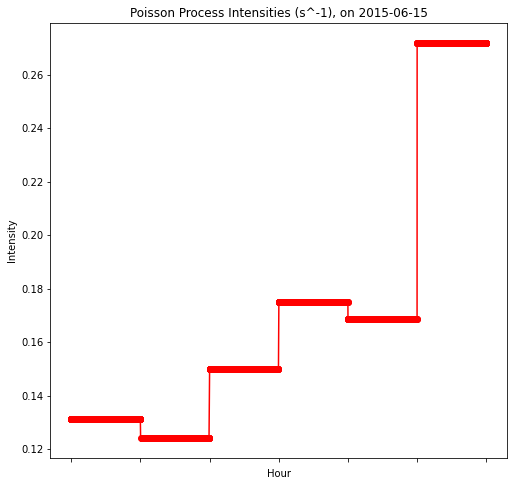

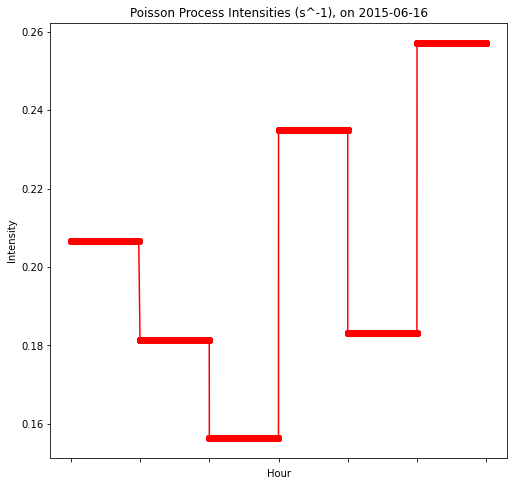

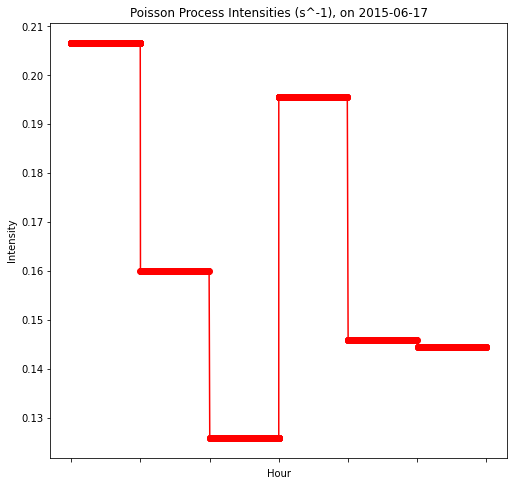

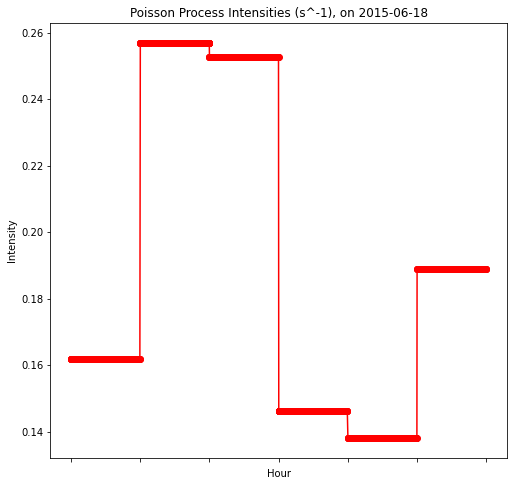

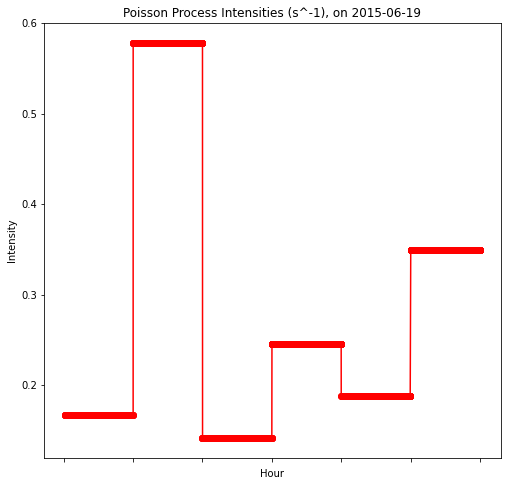

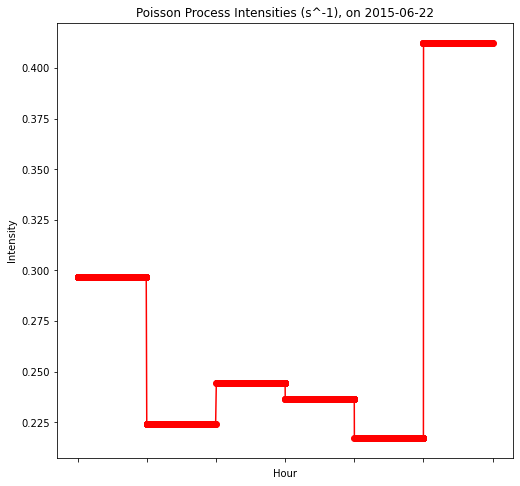

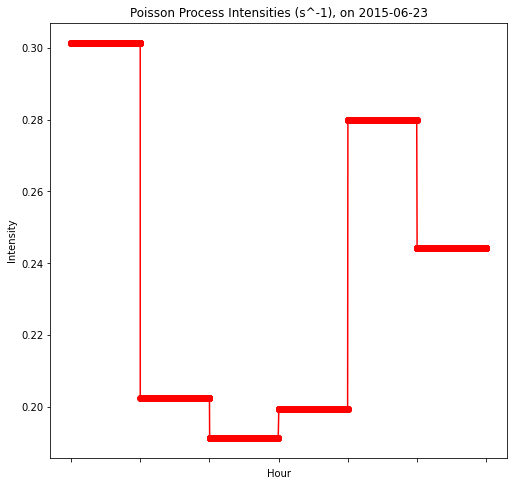

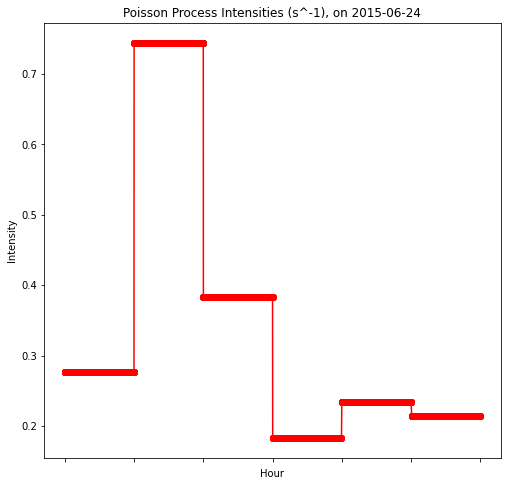

In [ ]:
unities_in_secondes = 1 # Intensities in second^-1
N_hours = 1
T = 3600*(N_hours)/unities_in_secondes # référentiel en secondes
resample_str = '1H'
unities_str = '(s^-1)'
df_trades = get_and_plot_intensities_by_day(df_trades, unities_in_secondes, N_hours, resample_str, unities_str)

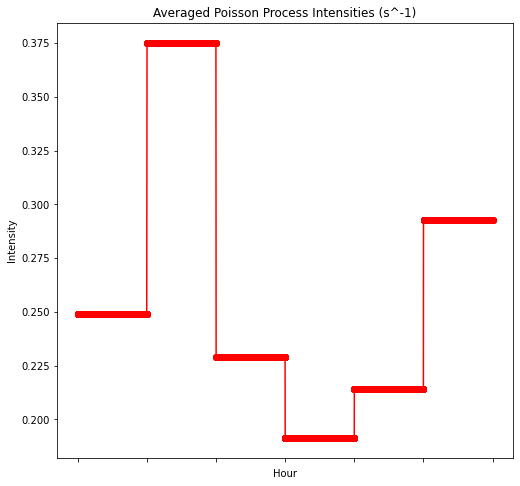

In [ ]:
period_hours = N_hours
df_trades = get_and_plot_average_intensities_hours(df_trades, resample_str, period_hours)

On remarque une forte activité de 11h à midi (hypothèse: trades avant le déjeuner?) ainsi qu'une forte activité de 15 à 16h, ce qui nous permet de renforcer l'hypothèse liée à l'ouverture de la bourse US.

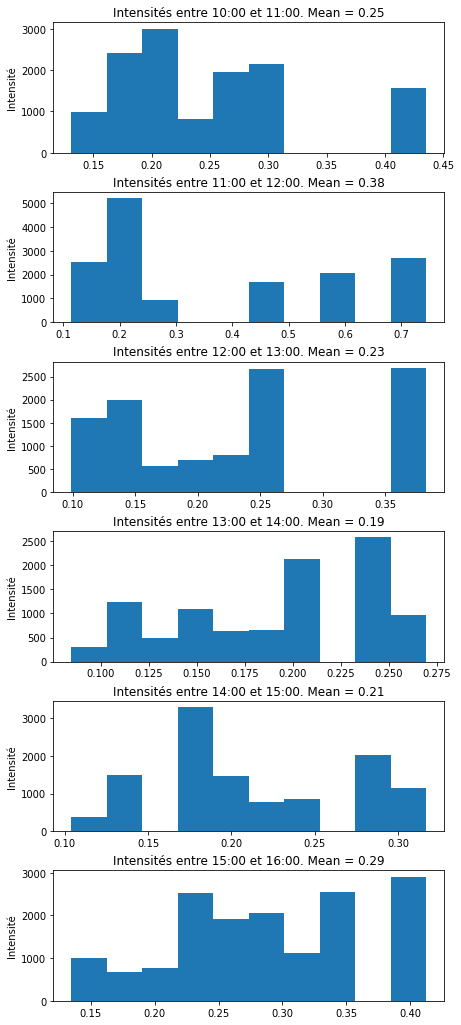

In [ ]:
resample_str = '1H'
time_sets = ['10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00']
bool_long_title = True
plot_hist_from_intensities(df_trades, time_sets, resample_str, bool_long_title)

Et ces derniers histogrammes nous permettent d'apprécier l'évolution de la distribution de l'intensité à travers la journée plus en détail.

### Processus de Poisson inhomogène à intensité déterministe





Dans la suite, nous allons développer une procédure permettant de calibrer numériquement sur ces données,
un processus de Poisson inhomogène d’intensité déterministe $\lambda(t)$ supposée variable pendant la journée, et
constante d’un journée à l’autre.

En effet nous pouvons étendre la méthode précédente en considérant des intervalles de plus en plus réduits ce qui nous donne une approximation d'un processus de Poisson inhomogène.

In [ ]:
def get_and_plot_average_intensities_minutes(df_trades, resample_str, period_minutes):
  # Aggregate
  df_trades['minutes'] = df_trades['datetime'].dt.minute
  df_trades['hours'] = df_trades['datetime'].dt.hour
  df_trades[resample_str + '_intensities_averaged'] =  df_trades.groupby([df_trades.hours, df_trades.minutes // period_minutes * period_minutes])[resample_str + '_intensities'].transform('mean')
  # Plot
  fig = plt.figure(figsize=(18,8))
  ax = fig.add_subplot(121)
  ax.set_ylabel('Intensity'); ax.set_xlabel('Hour')
  ax.set_title('Averaged Poisson Process Intensities ' + str(unities_str))
  ax.set_xticklabels([])
  ax.plot(df_trades[df_trades.date == df_trades.date[0]][resample_str + '_intensities_averaged'], 'ro-')
  plt.show()
  return df_trades

Comme précédémment on trace les intensités jour par jour, puis moyennées sur l'ensemble des jours :

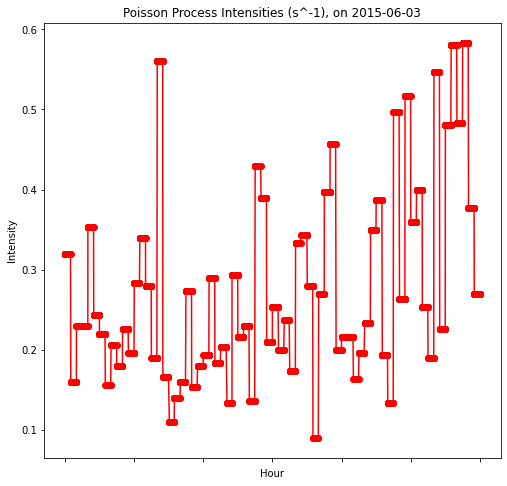

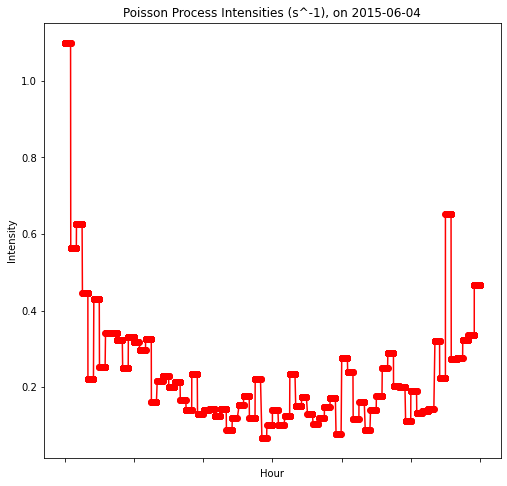

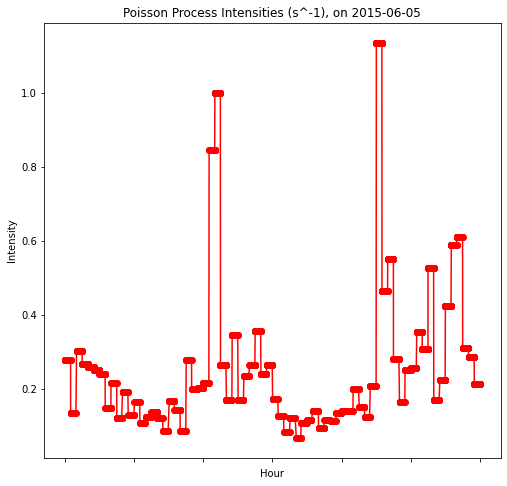

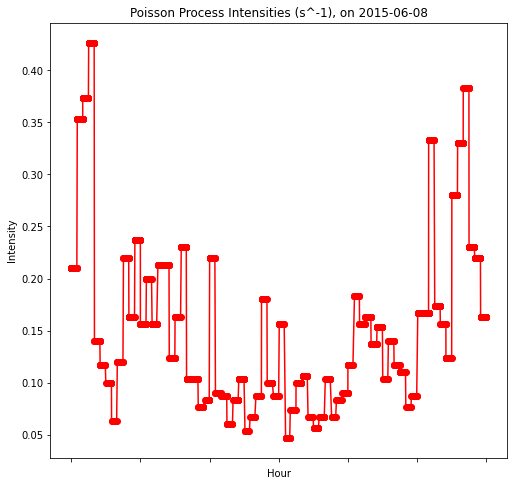

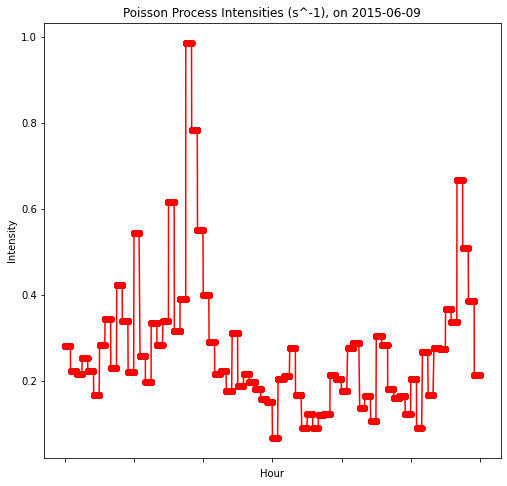

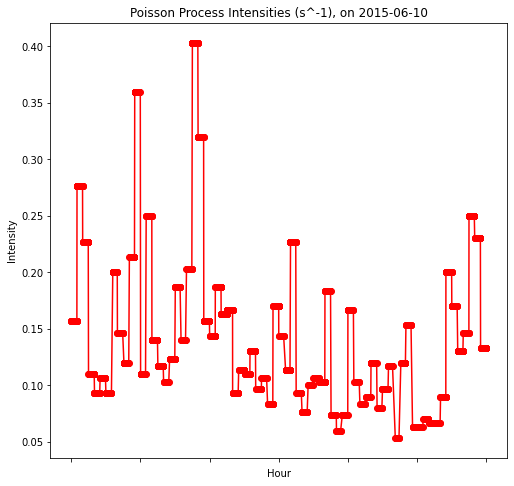

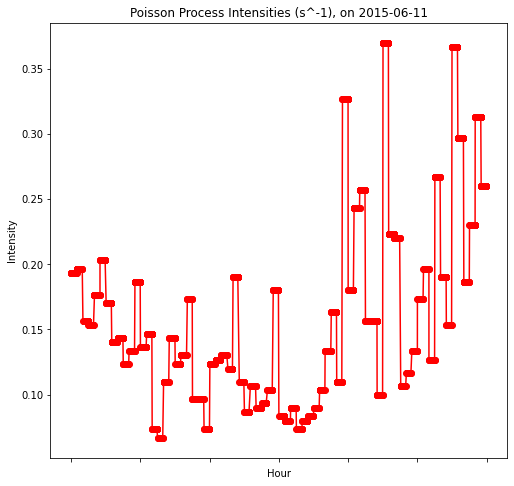

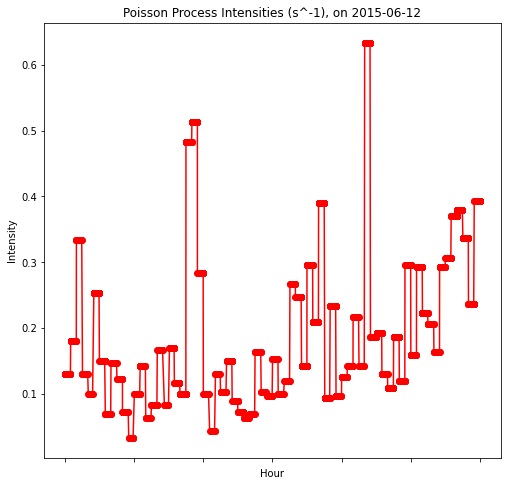

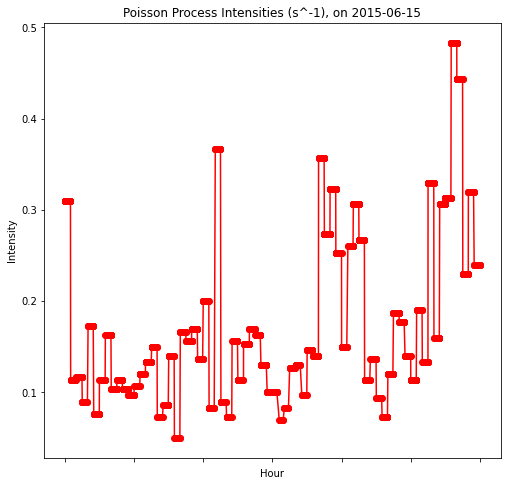

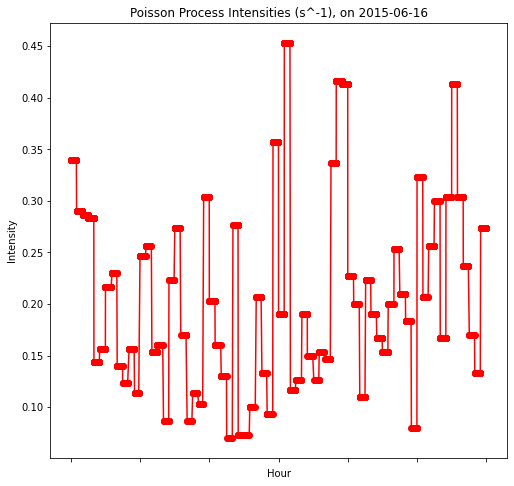

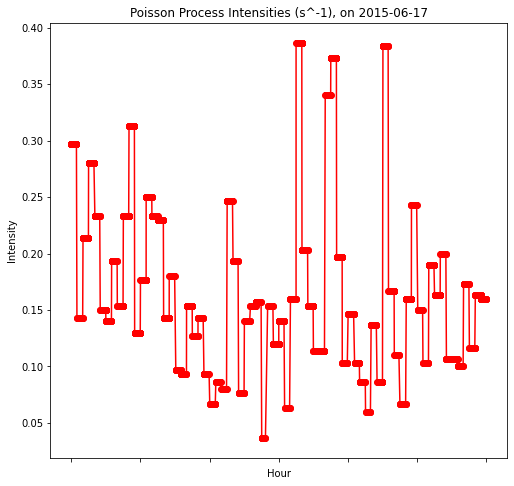

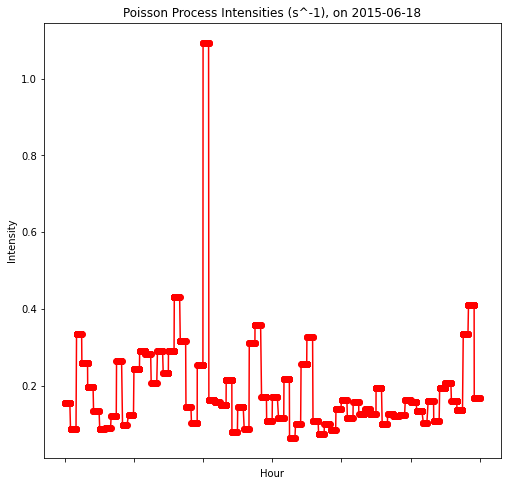

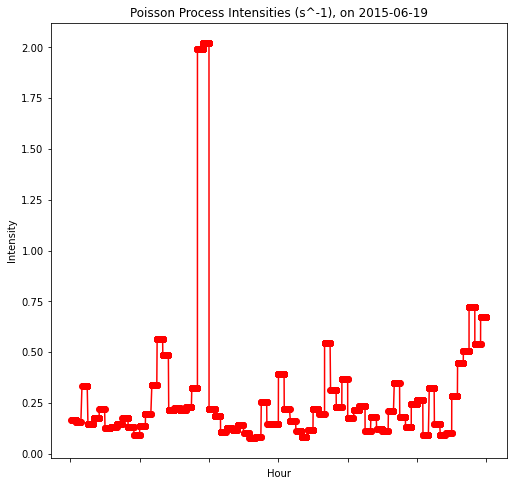

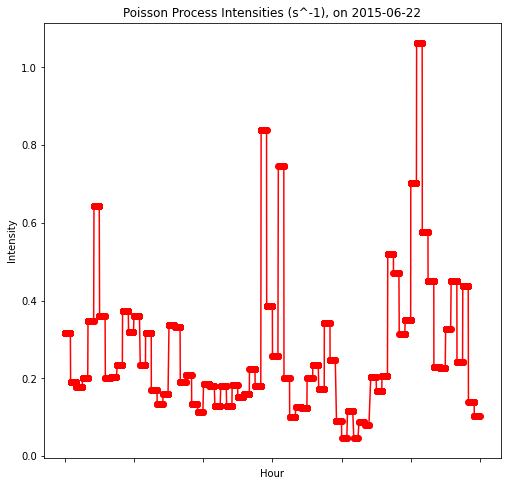

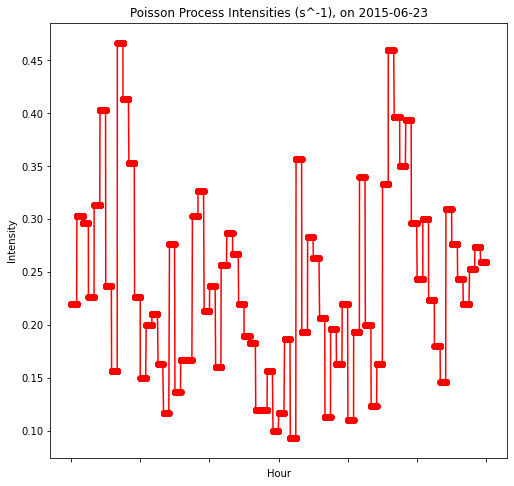

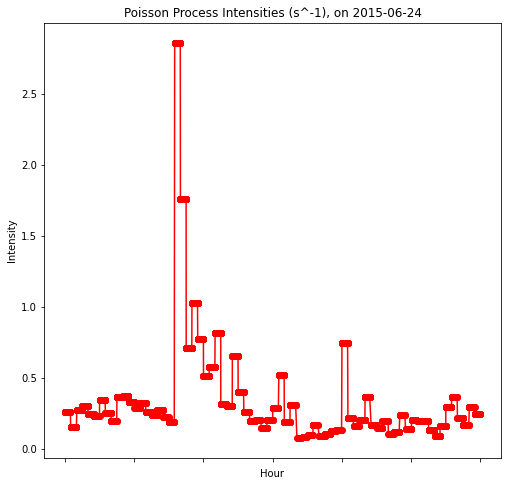

In [ ]:
# A faire : juste prendre les mêmes fonctions avec resample('5min')
unities_in_secondes = 1 # Intensities in second^-1
N_hours = 1/12
period_hours = N_hours
T = 3600*(N_hours)/unities_in_secondes # référentiel en secondes
resample_str = '5min'
unities_str = '(s^-1)'
df_trades = get_and_plot_intensities_by_day(df_trades, unities_in_secondes, N_hours, resample_str, unities_str)

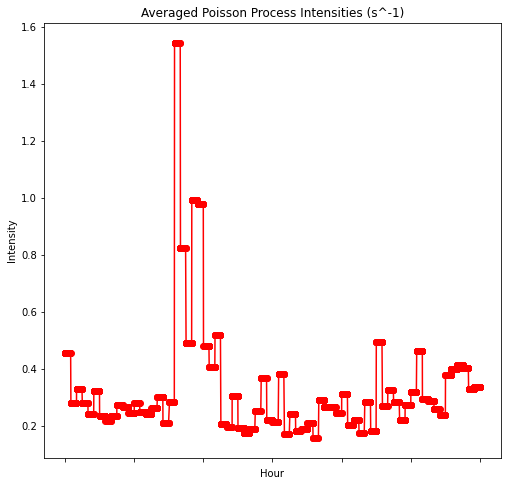

In [ ]:
period_minutes = 5
df_trades = get_and_plot_average_intensities_minutes(df_trades, resample_str, period_minutes)

Ce dernier graphique moyenné sur l'ensemble des jours nous permet d'apprécier un phénomène plus en détail que précédemment : Le pic d'intensité très marqué avant midi, certainement dû à l'activité des traders avant la pause déjeuner. On remarque sur les graphiques précédents que seulement certains jours présentent ce pic marqué, il pourrait donc être intéréssant de trouver des variables explicatives pour ce phénomène, ce qui pourrait permettre le développement d'une stratégie systématique. Ce  même phénomène de "pics" très marqués durant certains jours semblent se présenter plusieurs fois durant l'après midi.

Nous traçons également les histogrammes par tranche de 5 minutes :

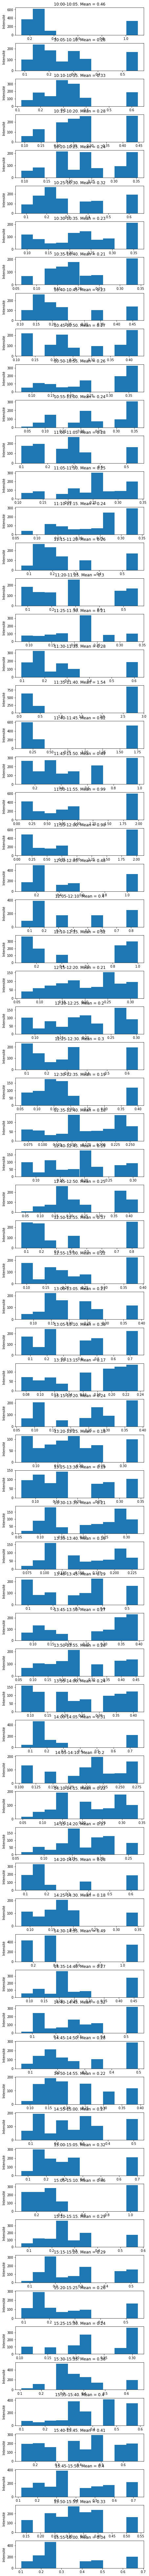

In [ ]:
resample_str = '5min'
time_sets = []
for h in [10, 11, 12, 13, 14, 15]:
  for min in [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]:
    time_sets.append(str(h) + ':' + str(min)) if (min not in [0,5]) else time_sets.append(str(h) + ':0' + str(min))
time_sets.append('16:00')
bool_long_title = False
plot_hist_from_intensities(df_trades, time_sets, resample_str, bool_long_title)

L'ajout d'information apporté par ces histogrammes pourrait permettre de développer une stratégie systèmatique plus précise, tirant partie des de l'évolution de l'activité de trading à travers la journée.

## Analyse de données de carnets d’ordres

Nous nous intéressons désormais aux données de carnet d'ordre. On conserve uniquement au jour du 10 Juin 2015, date également présente dans nos données de trades ce qui permettra une comparaison.

### Chargement des données

In [ ]:
trades_bool = False 
dates_list = ['2015-06-10']
df_book = load_data(dates_list, trades_bool)
df_book

Unnamed: 1  ...             time
xltime                                           ...                 
2015-06-10 10:00:00.016992+02:00          54.45  ...  10:00:00.016992
2015-06-10 10:00:00.016992+02:00          54.45  ...  10:00:00.016992
2015-06-10 10:00:00.016992+02:00          54.45  ...  10:00:00.016992
2015-06-10 10:00:00.020966400+02:00       54.45  ...  10:00:00.020966
2015-06-10 10:00:00.020966400+02:00       54.45  ...  10:00:00.020966
...                                         ...  ...              ...
2015-06-10 15:59:59.980963200+02:00       55.08  ...  15:59:59.980963
2015-06-10 15:59:59.980963200+02:00       55.08  ...  15:59:59.980963
2015-06-10 15:59:59.987011200+02:00       55.08  ...  15:59:59.987011
2015-06-10 15:59:59.990985599+02:00       55.08  ...  15:59:59.990985
2015-06-10 15:59:59.990985599+02:00       55.08  ...  15:59:59.990985

[478853 rows x 43 columns]

### Preprocessing des données

La difficulté ici étant de définir un trade dans l'order book de manière cohérente avec la manière dont on l'avait défini dans le trading book. 
En fait la formule obtenue en (6) $\bar{\lambda}=\frac{N}{T}$ sera ici appliquée en considérant N comme "l'activité sur le marché" i.e le flow d'ordres et non pas le nombre de trades effectifs.

Obtenir le même résultat est en fait impossible puisque l'on manque d'information pour distinguer les différents types d'ordres, on s'intéressera donc surtout à la dynamique de l'intensité plus qu'à ses valeurs.

Par cohérence nous regroupons tout de même les lignes de données d'order books ayant le même datetime, puisque cela correspond à l'arrivé d'un seul ordre (Market Order qui consomme plusieurs ticks?). Pour une même datetime on conserve la dernière ligne qui correspond bien au dernier état de l'order book à ce datetime donné (ça n'a pas d'importance puisque l'on se contentera de compter les lignes).


In [ ]:
def group_orders(df_book):
  # à réecrire mieux
  df_book['datetime'] = df_book.index
  df_book = df_book.groupby('datetime')[df_book.columns].agg({col : 'last' for col in df_book.columns}) 
  return df_book

In [ ]:
df_book = group_orders(df_book)
df_book

Unnamed: 1  ...                            datetime
datetime                                         ...                                    
2015-06-10 10:00:00.016992+02:00          54.45  ...    2015-06-10 10:00:00.016992+02:00
2015-06-10 10:00:00.020966400+02:00       54.45  ... 2015-06-10 10:00:00.020966400+02:00
2015-06-10 10:00:00.140976+02:00          54.45  ...    2015-06-10 10:00:00.140976+02:00
2015-06-10 10:00:00.267033600+02:00       54.45  ... 2015-06-10 10:00:00.267033600+02:00
2015-06-10 10:00:00.323020800+02:00       54.45  ... 2015-06-10 10:00:00.323020800+02:00
...                                         ...  ...                                 ...
2015-06-10 15:59:59.919964800+02:00       55.09  ... 2015-06-10 15:59:59.919964800+02:00
2015-06-10 15:59:59.978976+02:00          55.08  ...    2015-06-10 15:59:59.978976+02:00
2015-06-10 15:59:59.980963200+02:00       55.08  ... 2015-06-10 15:59:59.980963200+02:00
2015-06-10 15:59:59.987011200+02:00       55.08  ... 2015-06-10 15:59:59.987011200+02:00
2015-06-10 15:59:59.990985599+02:00       55.08  ... 2015-06-10 15:59:59.990985599+02:00

[192229 rows x 44 columns]

### Processus de Poisson à intensité constante

Les fonctions suivantes nous permettent d'implémenter ce calcul à partir de nos données d'Order Book. Elles sont similaires à celles utilisées précédemment pour les trades.

In [ ]:
#fusionner fonctions avec trades
def get_book_count(df_book, resample_str):
  #df_book = df_book.groupby('datetime').count()
  agg_col_count = resample_str + '_count'
  df_book[agg_col_count] = df_book.resample(resample_str)['datetime'].transform('count') # ici on considère un trade = un trade price -> vérif
  return df_book
def get_poisson_intensities_book(df_book, resample_str, T):
  colname_intensities = resample_str + '_intensities' 
  df_book = get_book_count(df_book, resample_str)
  df_book[colname_intensities] = df_book[resample_str + '_count']/T
  return df_book

def get_and_plot_intensities_by_day_book(df_book, unities_in_secondes, N_hours, resample_str, unities_str):
  df_book = get_poisson_intensities_book(df_book, resample_str, T)
  for day in df_book.date.unique(): #day by day
    fig = plt.figure(figsize=(18,8))
    ax = fig.add_subplot(121)
    ax.set_ylabel('Intensity'); ax.set_xlabel('Hour')
    ax.set_title('Poisson Process Intensities ' + str(unities_str) + ', on ' + str(day))
    ax.set_xticklabels([])
    df_book_day = df_book[df_book.date==day]
    ax.plot(df_book_day[resample_str + '_intensities'], 'ro-')
    plt.show()
  return df_book

#### Jour par Jour

In [ ]:
unities_in_secondes = 1 # Intensities in second^-1
N_hours = 6
T = 3600*(N_hours)/unities_in_secondes # référentiel en secondes
resample_str = 'D'
unities_str = '(s^-1)'
df_book = get_poisson_intensities_book(df_book, resample_str, T)

In [ ]:
df_book['D_intensities'].unique() / 0.275

array([32.36178451])

On obtient une intensité environ 30 fois supérieure à l'intensité obtenue sur le trading book le 10 Juin. Ce qui signifierai qu'il y aurait 30 fois plus d'ordres que de trades ce qui nous paraît (peut être naïvement) assez surestimé. Malgré nos efforts aucune possible définition d'un trade dans l'order book nous a permit d'augmenter cette valeure.

### Par tranche de 2 heures

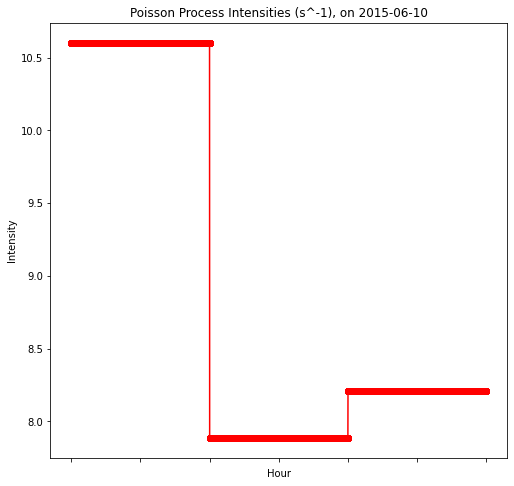

In [ ]:
unities_in_secondes = 1 # Intensities in second^-1
N_hours = 2
T = 3600*(N_hours)/unities_in_secondes # référentiel en secondes
resample_str = '2H'
unities_str = '(s^-1)'
df_book = get_and_plot_intensities_by_day_book(df_book, unities_in_secondes, N_hours, resample_str, unities_str)

En comparant avec nos résultats plus hauts, on obtient presque la même forme d'évolution de l'intensité par tranche de 2 heures, excepté qu'ici, la tranche 14h-16h est légèrement au dessus de la tranche 12h-14h à l'inverse de précédemment. Cela peut s'expliquer par le fait qu'en fin de journée les traders - en plus des trades effectifs -, effectuent un certains nombres de market orders et de cancel orders avant de terminer leur journée.

### Processus de Poisson inhomogène à intensité déterministe

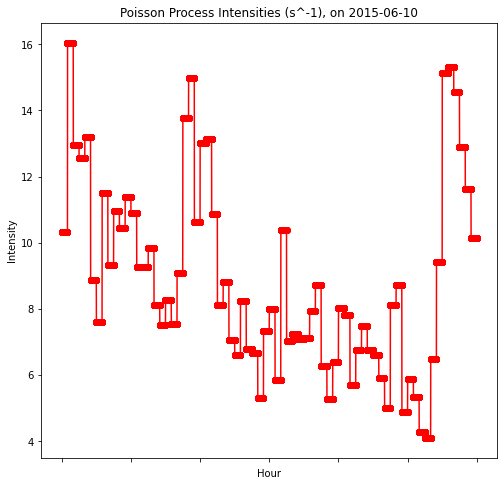

In [ ]:
unities_in_secondes = 1 # Intensities in second^-1
N_hours = 1/12
period_hours = N_hours
T = 3600*(N_hours)/unities_in_secondes # référentiel en secondes
resample_str = '5min'
unities_str = '(s^-1)'
df_book = get_and_plot_intensities_by_day_book(df_book, unities_in_secondes, N_hours, resample_str, unities_str)

Par tranche de 5 minutes on retrouve également la même forme que précédemment, avec 3 pics très marqués en début de journée, avant le déjeuner, et en toute fin de journée.
On remarque que ces 3 pics sont encore plus marqués, et cela peut s'expliquer par la raison donnée dans la section précédente.